# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Mon Jun  9 01:32:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.2 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install codecarbon


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.0.1
    Uninstalling termcolor-3.0.1:
      Successfully uninstalled termcolor-3.0.1
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.9.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from codecarbon import EmissionsTracker


import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_19/911096143.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2025-06-09 01:32:54.511638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749432774.747948      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749432774.820566      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Description of the data set

The dataset contains approximately 12,000 images divided into seven categories of waste, including paper, metal, cardboard, trash, glass, biological, and plastic.


# Data Preprcessing

In [5]:
prepare_data_emission_tracker = EmissionsTracker()
prepare_data_emission_tracker.start()

[codecarbon WARNING @ 01:33:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 01:33:07] [setup] RAM Tracking...
[codecarbon INFO @ 01:33:07] [setup] CPU Tracking...
[codecarbon WARNING @ 01:33:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 01:33:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 01:33:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 01:33:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 01:33:08] [setup] GPU Tracking...
[codecarbon INFO @ 01:33:08] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:33:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

In [6]:
data_dir = '/kaggle/input/dwaste-data-v4'

Cleaning the working directory if there are any files in it

In [7]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [8]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

[codecarbon INFO @ 01:33:26] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:33:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:33:26] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 01:33:26] Energy consumed for all GPUs : 0.000089 kWh. Total GPU Power : 21.278991418417124 W
[codecarbon INFO @ 01:33:26] 0.000349 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:33:41] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:33:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:33:41] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 01:33:41] Energy consumed for all GPUs : 0.000177 kWh. Total GPU Power : 21.212863304981205 W
[codecarbon INFO @ 01:33:41] 0.000698 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:33:56] Energy consumed for RAM : 0.000250 kWh. RAM Power :

'/kaggle/working/dataset'

In [9]:
data_dir  = '/kaggle/working/dataset'

In [10]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [11]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/cardboard/cardboard_313.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_313.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_2088.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_2088.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_2038.jpg is not an image
/kaggle/working/dataset/plastic/plastic_2038.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_160.jpg is not an image
/kaggle/working/dataset/plastic/plastic_160.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_613.jpg is not an image
/kaggle/working/dataset/plastic/plastic_613.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_603.jpg is not an image
/kaggle/working/dataset/plastic/plastic_603.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_1678.jpg is a webp, not accepted by TensorFl

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [12]:
os.mkdir('data')

In [13]:
os.chdir('data')

In [14]:
os.getcwd()

'/kaggle/working/data'

In [15]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [16]:
os.chdir('/kaggle/working/')

In [17]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [18]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [19]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 11151 files [00:01, 6801.79 files/s]


In [20]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [21]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [22]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

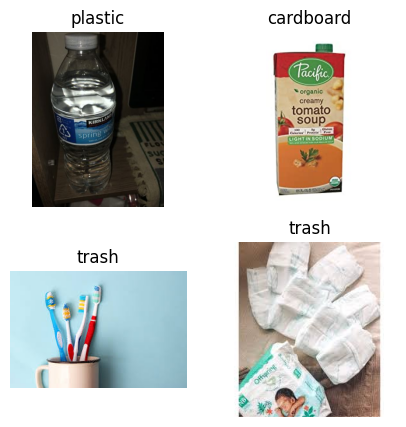

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))  # Display 4 images
axes = axes.ravel()

for i in np.arange(0, 4):
    category = random.choice(os.listdir(train_path))  # Randomly choose a class
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir))  # Randomly choose an image from that class

    img = plt.imread(os.path.join(class_dir, image))
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [24]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Trash: 617
Metal: 795
Biological: 786
Cardboard: 1446
Glass: 2431
Plastic: 1528
Paper: 1315

Total number of train images: 8918


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [25]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [26]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[786, 1446, 2431, 795, 1315, 1528, 617]

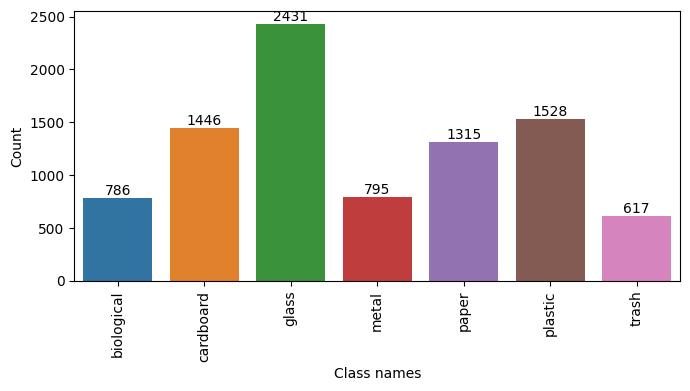

In [27]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

### Class Imbalance in the Dataset

A situation where one or more classes contain a significantly larger number of images is known as **class imbalance**. In our case, this imbalance is expected and reflects the nature of real-world waste distribution. For example:

- **Glass**: 3,039 images  
- **Plastic**: 1,915 images  
- **Cardboard**: 1,810 images  
- **Paper**: 1,650 images  
- **Metal**: 994 images  
- **Biological**: 983 images  
- **Trash**: 772 images  

This imbalance can negatively affect the model’s performance, leading it to favor the larger classes and perform poorly on the underrepresented ones.

To address this issue, we will apply **random undersampling**, a technique that balances the dataset by randomly removing some examples from the overrepresented classes. This helps reduce model bias and improves its ability to generalize across all categories.


Excluding some random images from the training data

In [28]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 0 in trash
Deleted 0 in metal
Deleted 0 in biological
Deleted 446 in cardboard
Deleted 1431 in glass
Deleted 528 in plastic
Deleted 315 in paper


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [29]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

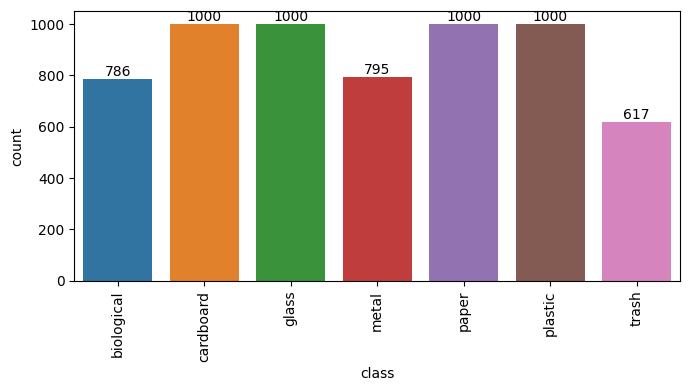

In [30]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [31]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [32]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 447.6124
Mean Height: 423.3937


Let's set the size of the input data (image size) taking into account the found average values

In [33]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [34]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [35]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [36]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 6198 files belonging to 7 classes.


I0000 00:00:1749432863.394669      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749432863.395490      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [37]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 1121 files belonging to 7 classes.


In [38]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 1112 files belonging to 7 classes.


Create directories for train and test logs and write logs to it 

In [39]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


In [40]:

prepare_data_emissions: float = prepare_data_emission_tracker.stop()
print(f"Prepare Data Carbon Emissions: {prepare_data_emissions} kg")

[codecarbon INFO @ 01:34:25] Energy consumed for RAM : 0.000410 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:34:25] Delta energy consumed for CPU with constant : 0.000164 kWh, power : 42.5 W
[codecarbon INFO @ 01:34:25] Energy consumed for All CPU : 0.000872 kWh
[codecarbon INFO @ 01:34:25] Energy consumed for all GPUs : 0.000455 kWh. Total GPU Power : 26.326578753207315 W
[codecarbon INFO @ 01:34:25] 0.001737 kWh of electricity used since the beginning.


Prepare Data Carbon Emissions: 0.0007863350526269881 kg


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the ResNet101 model was selected.


In [41]:
develop_model_emission_tracker = EmissionsTracker()
develop_model_emission_tracker.start()

[codecarbon WARNING @ 01:34:25] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 01:34:25] [setup] RAM Tracking...
[codecarbon INFO @ 01:34:25] [setup] CPU Tracking...
[codecarbon WARNING @ 01:34:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 01:34:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 01:34:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 01:34:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 01:34:26] [setup] GPU Tracking...
[codecarbon INFO @ 01:34:26] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:34:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Loading the model

In [42]:
base_model = tf.keras.applications.resnet.ResNet101(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Let's see what the architecture of the pretrained model looks like

In [43]:
base_model.summary()

Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 400, 400, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 406, 406, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 200, 200, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 200, 200, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 200, 200, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 202, 202, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 100, 100, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 100, 100, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 100, 100, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 100, 100, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 100, 100, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 100, 100, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 100, 100, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 100, 100, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 100, 100, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 42,552,832 (162.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [44]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [45]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

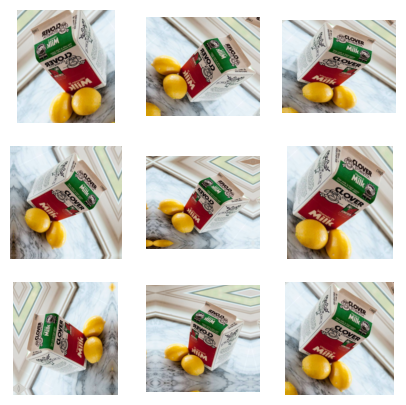

In [46]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [47]:
name="ResNet101"

ResNet101_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [48]:
ResNet101_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [49]:
ResNet101_model.summary()

Model: "ResNet101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, None, None, 2048)    │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,921,351 (163.73 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [50]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [51]:
ResNet101_callback = create_callback(name)

Let's set the number of training epochs

In [52]:
EPOCH=20

Let's train the model

In [53]:
import time
start_time = time.time()
ResNet101_history = ResNet101_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=ResNet101_callback)

Epoch 1/20


[codecarbon INFO @ 01:34:44] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:34:44] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 01:34:44] Energy consumed for All CPU : 0.000178 kWh
[codecarbon INFO @ 01:34:44] Energy consumed for all GPUs : 0.000230 kWh. Total GPU Power : 55.002557219843595 W
[codecarbon INFO @ 01:34:44] 0.000491 kWh of electricity used since the beginning.
I0000 00:00:1749432897.616234     196 cuda_dnn.cc:529] Loaded cuDNN version 90300
[codecarbon INFO @ 01:34:59] Energy consumed for RAM : 0.000166 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:34:59] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 01:34:59] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 01:34:59] Energy consumed for all GPUs : 0.000475 kWh. Total GPU Power : 59.09261786640872 W
[codecarbon INFO @ 01:34:59] 0.000995 kWh of electricity used since the beginning.

  6/194 ━━━━━━━━━━━━━━━━━━━━ 7:59 3s/step - accuracy: 0.1663 - loss: 2.4593

[codecarbon INFO @ 01:35:14] Energy consumed for RAM : 0.000250 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:35:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:35:14] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 01:35:14] Energy consumed for all GPUs : 0.000877 kWh. Total GPU Power : 96.57972327426981 W
[codecarbon INFO @ 01:35:14] 0.001658 kWh of electricity used since the beginning.


 12/194 ━━━━━━━━━━━━━━━━━━━━ 7:50 3s/step - accuracy: 0.2406 - loss: 2.1899

[codecarbon INFO @ 01:35:29] Energy consumed for RAM : 0.000333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:35:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:35:29] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 01:35:29] Energy consumed for all GPUs : 0.001280 kWh. Total GPU Power : 96.6034083565979 W
[codecarbon INFO @ 01:35:29] 0.002320 kWh of electricity used since the beginning.


 18/194 ━━━━━━━━━━━━━━━━━━━━ 7:17 2s/step - accuracy: 0.2951 - loss: 2.0044

[codecarbon INFO @ 01:35:44] Energy consumed for RAM : 0.000416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:35:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:35:44] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 01:35:44] Energy consumed for all GPUs : 0.001682 kWh. Total GPU Power : 96.68269281926014 W
[codecarbon INFO @ 01:35:44] 0.002983 kWh of electricity used since the beginning.


 27/194 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.3570 - loss: 1.8082

[codecarbon INFO @ 01:35:59] Energy consumed for RAM : 0.000499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:35:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:35:59] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 01:35:59] Energy consumed for all GPUs : 0.002086 kWh. Total GPU Power : 96.93590712470449 W
[codecarbon INFO @ 01:35:59] 0.003647 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 6:11 2s/step - accuracy: 0.3898 - loss: 1.7141

[codecarbon INFO @ 01:36:14] Energy consumed for RAM : 0.000583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:36:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:36:14] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 01:36:14] Energy consumed for all GPUs : 0.002489 kWh. Total GPU Power : 96.68960892774483 W
[codecarbon INFO @ 01:36:14] 0.004310 kWh of electricity used since the beginning.


 40/194 ━━━━━━━━━━━━━━━━━━━━ 5:49 2s/step - accuracy: 0.4223 - loss: 1.6239

[codecarbon INFO @ 01:36:29] Energy consumed for RAM : 0.000666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:36:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:36:29] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 01:36:29] Energy consumed for all GPUs : 0.002889 kWh. Total GPU Power : 96.1829382420465 W
[codecarbon INFO @ 01:36:29] 0.004971 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:36:29] 0.018746 g.CO2eq/s mean an estimation of 591.1789896869683 kg.CO2eq/year


 45/194 ━━━━━━━━━━━━━━━━━━━━ 5:45 2s/step - accuracy: 0.4420 - loss: 1.5698

[codecarbon INFO @ 01:36:44] Energy consumed for RAM : 0.000749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:36:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:36:44] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 01:36:44] Energy consumed for all GPUs : 0.003293 kWh. Total GPU Power : 96.80005002517933 W
[codecarbon INFO @ 01:36:44] 0.005634 kWh of electricity used since the beginning.


 51/194 ━━━━━━━━━━━━━━━━━━━━ 5:35 2s/step - accuracy: 0.4621 - loss: 1.5139

[codecarbon INFO @ 01:36:59] Energy consumed for RAM : 0.000833 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:36:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:36:59] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 01:36:59] Energy consumed for all GPUs : 0.003693 kWh. Total GPU Power : 96.12872400285224 W
[codecarbon INFO @ 01:36:59] 0.006295 kWh of electricity used since the beginning.


 57/194 ━━━━━━━━━━━━━━━━━━━━ 5:21 2s/step - accuracy: 0.4793 - loss: 1.4662

[codecarbon INFO @ 01:37:14] Energy consumed for RAM : 0.000916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:37:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:37:14] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 01:37:14] Energy consumed for all GPUs : 0.004095 kWh. Total GPU Power : 96.42023382703917 W
[codecarbon INFO @ 01:37:14] 0.006957 kWh of electricity used since the beginning.


 63/194 ━━━━━━━━━━━━━━━━━━━━ 5:08 2s/step - accuracy: 0.4948 - loss: 1.4238

[codecarbon INFO @ 01:37:29] Energy consumed for RAM : 0.000999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:37:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:37:29] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 01:37:29] Energy consumed for all GPUs : 0.004497 kWh. Total GPU Power : 96.65247646135569 W
[codecarbon INFO @ 01:37:29] 0.007620 kWh of electricity used since the beginning.


 70/194 ━━━━━━━━━━━━━━━━━━━━ 4:51 2s/step - accuracy: 0.5111 - loss: 1.3801

[codecarbon INFO @ 01:37:44] Energy consumed for RAM : 0.001082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:37:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:37:44] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 01:37:44] Energy consumed for all GPUs : 0.004897 kWh. Total GPU Power : 96.02201065290983 W
[codecarbon INFO @ 01:37:44] 0.008280 kWh of electricity used since the beginning.


 78/194 ━━━━━━━━━━━━━━━━━━━━ 4:28 2s/step - accuracy: 0.5270 - loss: 1.3369

[codecarbon INFO @ 01:37:59] Energy consumed for RAM : 0.001166 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:37:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:37:59] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 01:37:59] Energy consumed for all GPUs : 0.005300 kWh. Total GPU Power : 96.62414163213099 W
[codecarbon INFO @ 01:37:59] 0.008943 kWh of electricity used since the beginning.


 85/194 ━━━━━━━━━━━━━━━━━━━━ 4:11 2s/step - accuracy: 0.5392 - loss: 1.3037

[codecarbon INFO @ 01:38:14] Energy consumed for RAM : 0.001249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:38:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:38:14] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 01:38:14] Energy consumed for all GPUs : 0.005699 kWh. Total GPU Power : 95.95857570756867 W
[codecarbon INFO @ 01:38:14] 0.009603 kWh of electricity used since the beginning.


 92/194 ━━━━━━━━━━━━━━━━━━━━ 3:52 2s/step - accuracy: 0.5501 - loss: 1.2736

[codecarbon INFO @ 01:38:29] Energy consumed for RAM : 0.001332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:38:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:38:29] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 01:38:29] Energy consumed for all GPUs : 0.006099 kWh. Total GPU Power : 95.87888385817799 W
[codecarbon INFO @ 01:38:29] 0.010262 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:38:29] 0.019958 g.CO2eq/s mean an estimation of 629.403354550874 kg.CO2eq/year


100/194 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.5613 - loss: 1.2424

[codecarbon INFO @ 01:38:44] Energy consumed for RAM : 0.001416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:38:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:38:44] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 01:38:44] Energy consumed for all GPUs : 0.006499 kWh. Total GPU Power : 96.25083242866813 W
[codecarbon INFO @ 01:38:44] 0.010924 kWh of electricity used since the beginning.


107/194 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.5703 - loss: 1.2173

[codecarbon INFO @ 01:38:59] Energy consumed for RAM : 0.001499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:38:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:38:59] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 01:38:59] Energy consumed for all GPUs : 0.006899 kWh. Total GPU Power : 95.91722767747306 W
[codecarbon INFO @ 01:38:59] 0.011584 kWh of electricity used since the beginning.


114/194 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.5787 - loss: 1.1940

[codecarbon INFO @ 01:39:14] Energy consumed for RAM : 0.001582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:39:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:39:14] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 01:39:14] Energy consumed for all GPUs : 0.007300 kWh. Total GPU Power : 96.33842462528133 W
[codecarbon INFO @ 01:39:14] 0.012245 kWh of electricity used since the beginning.


119/194 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.5844 - loss: 1.1783

[codecarbon INFO @ 01:39:29] Energy consumed for RAM : 0.001665 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:39:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:39:29] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 01:39:29] Energy consumed for all GPUs : 0.007700 kWh. Total GPU Power : 95.8557597172583 W
[codecarbon INFO @ 01:39:29] 0.012905 kWh of electricity used since the beginning.


126/194 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.5917 - loss: 1.1579

[codecarbon INFO @ 01:39:44] Energy consumed for RAM : 0.001749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:39:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:39:44] Energy consumed for All CPU : 0.003717 kWh
[codecarbon INFO @ 01:39:44] Energy consumed for all GPUs : 0.008099 kWh. Total GPU Power : 95.8364977867007 W
[codecarbon INFO @ 01:39:44] 0.013564 kWh of electricity used since the beginning.


133/194 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.5986 - loss: 1.1390

[codecarbon INFO @ 01:39:59] Energy consumed for RAM : 0.001832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:39:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:39:59] Energy consumed for All CPU : 0.003894 kWh
[codecarbon INFO @ 01:39:59] Energy consumed for all GPUs : 0.008499 kWh. Total GPU Power : 96.07571269012993 W
[codecarbon INFO @ 01:39:59] 0.014224 kWh of electricity used since the beginning.


142/194 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.6069 - loss: 1.1165

[codecarbon INFO @ 01:40:14] Energy consumed for RAM : 0.001915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:40:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:40:14] Energy consumed for All CPU : 0.004071 kWh
[codecarbon INFO @ 01:40:14] Energy consumed for all GPUs : 0.008898 kWh. Total GPU Power : 95.83861427942277 W
[codecarbon INFO @ 01:40:14] 0.014884 kWh of electricity used since the beginning.


150/194 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.6137 - loss: 1.0980

[codecarbon INFO @ 01:40:29] Energy consumed for RAM : 0.001998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:40:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:40:29] Energy consumed for All CPU : 0.004248 kWh
[codecarbon INFO @ 01:40:29] Energy consumed for all GPUs : 0.009297 kWh. Total GPU Power : 95.82578057079468 W
[codecarbon INFO @ 01:40:29] 0.015543 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:40:29] 0.019916 g.CO2eq/s mean an estimation of 628.0734781944531 kg.CO2eq/year


156/194 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - accuracy: 0.6184 - loss: 1.0849

[codecarbon INFO @ 01:40:44] Energy consumed for RAM : 0.002082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:40:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:40:44] Energy consumed for All CPU : 0.004424 kWh
[codecarbon INFO @ 01:40:44] Energy consumed for all GPUs : 0.009697 kWh. Total GPU Power : 96.09211810694075 W
[codecarbon INFO @ 01:40:44] 0.016203 kWh of electricity used since the beginning.


162/194 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.6230 - loss: 1.0724

[codecarbon INFO @ 01:40:59] Energy consumed for RAM : 0.002165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:40:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:40:59] Energy consumed for All CPU : 0.004601 kWh
[codecarbon INFO @ 01:40:59] Energy consumed for all GPUs : 0.010096 kWh. Total GPU Power : 95.85236605852373 W
[codecarbon INFO @ 01:40:59] 0.016863 kWh of electricity used since the beginning.


169/194 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6280 - loss: 1.0586

[codecarbon INFO @ 01:41:14] Energy consumed for RAM : 0.002248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:41:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:41:14] Energy consumed for All CPU : 0.004778 kWh
[codecarbon INFO @ 01:41:14] Energy consumed for all GPUs : 0.010497 kWh. Total GPU Power : 96.09334657272619 W
[codecarbon INFO @ 01:41:14] 0.017523 kWh of electricity used since the beginning.


178/194 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6340 - loss: 1.0421

[codecarbon INFO @ 01:41:29] Energy consumed for RAM : 0.002332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:41:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:41:29] Energy consumed for All CPU : 0.004955 kWh
[codecarbon INFO @ 01:41:29] Energy consumed for all GPUs : 0.010895 kWh. Total GPU Power : 95.77642854765844 W
[codecarbon INFO @ 01:41:29] 0.018183 kWh of electricity used since the beginning.


186/194 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6389 - loss: 1.0286

[codecarbon INFO @ 01:41:44] Energy consumed for RAM : 0.002415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:41:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:41:44] Energy consumed for All CPU : 0.005132 kWh
[codecarbon INFO @ 01:41:44] Energy consumed for all GPUs : 0.011294 kWh. Total GPU Power : 95.67409458993245 W
[codecarbon INFO @ 01:41:44] 0.018841 kWh of electricity used since the beginning.


192/194 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6424 - loss: 1.0191

[codecarbon INFO @ 01:41:59] Energy consumed for RAM : 0.002498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:41:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:41:59] Energy consumed for All CPU : 0.005310 kWh
[codecarbon INFO @ 01:41:59] Energy consumed for all GPUs : 0.011695 kWh. Total GPU Power : 96.25863880389456 W
[codecarbon INFO @ 01:41:59] 0.019503 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6435 - loss: 1.0160

[codecarbon INFO @ 01:42:14] Energy consumed for RAM : 0.002582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:42:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:42:14] Energy consumed for All CPU : 0.005487 kWh
[codecarbon INFO @ 01:42:14] Energy consumed for all GPUs : 0.012042 kWh. Total GPU Power : 83.36641366150384 W
[codecarbon INFO @ 01:42:14] 0.020110 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:42:29] Energy consumed for RAM : 0.002665 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:42:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:42:29] Energy consumed for All CPU : 0.005664 kWh
[codecarbon INFO @ 01:42:29] Energy consumed for all GPUs : 0.012442 kWh. Total GPU Power : 95.92027973874717 W
[codecarbon INFO @ 01:42:29] 0.020770 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:42:29] 0.019715 g.CO2eq/s mean an estimation of 621.74082971

194/194 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.6441 - loss: 1.0144 - val_accuracy: 0.8561 - val_loss: 0.4181 - learning_rate: 0.0010
Epoch 2/20
  4/194 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.7428 - loss: 0.6401

[codecarbon INFO @ 01:42:44] Energy consumed for RAM : 0.002748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:42:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:42:44] Energy consumed for All CPU : 0.005841 kWh
[codecarbon INFO @ 01:42:44] Energy consumed for all GPUs : 0.012837 kWh. Total GPU Power : 94.9068103260358 W
[codecarbon INFO @ 01:42:44] 0.021426 kWh of electricity used since the beginning.


 11/194 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.7867 - loss: 0.5392

[codecarbon INFO @ 01:42:59] Energy consumed for RAM : 0.002831 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:42:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:42:59] Energy consumed for All CPU : 0.006018 kWh
[codecarbon INFO @ 01:42:59] Energy consumed for all GPUs : 0.013235 kWh. Total GPU Power : 95.6097123588657 W
[codecarbon INFO @ 01:42:59] 0.022084 kWh of electricity used since the beginning.


 17/194 ━━━━━━━━━━━━━━━━━━━━ 6:27 2s/step - accuracy: 0.8016 - loss: 0.5074

[codecarbon INFO @ 01:43:14] Energy consumed for RAM : 0.002915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:43:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:43:14] Energy consumed for All CPU : 0.006194 kWh
[codecarbon INFO @ 01:43:14] Energy consumed for all GPUs : 0.013634 kWh. Total GPU Power : 95.8344727093093 W
[codecarbon INFO @ 01:43:14] 0.022743 kWh of electricity used since the beginning.


 26/194 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.8092 - loss: 0.4941

[codecarbon INFO @ 01:43:29] Energy consumed for RAM : 0.002998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:43:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:43:29] Energy consumed for All CPU : 0.006371 kWh
[codecarbon INFO @ 01:43:29] Energy consumed for all GPUs : 0.014035 kWh. Total GPU Power : 96.12729096436428 W
[codecarbon INFO @ 01:43:29] 0.023404 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 5:35 2s/step - accuracy: 0.8125 - loss: 0.4869

[codecarbon INFO @ 01:43:44] Energy consumed for RAM : 0.003081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:43:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:43:44] Energy consumed for All CPU : 0.006548 kWh
[codecarbon INFO @ 01:43:44] Energy consumed for all GPUs : 0.014434 kWh. Total GPU Power : 95.91245927027269 W
[codecarbon INFO @ 01:43:44] 0.024064 kWh of electricity used since the beginning.


 41/194 ━━━━━━━━━━━━━━━━━━━━ 5:07 2s/step - accuracy: 0.8155 - loss: 0.4800

[codecarbon INFO @ 01:43:59] Energy consumed for RAM : 0.003165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:43:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:43:59] Energy consumed for All CPU : 0.006725 kWh
[codecarbon INFO @ 01:43:59] Energy consumed for all GPUs : 0.014833 kWh. Total GPU Power : 95.75369467806087 W
[codecarbon INFO @ 01:43:59] 0.024723 kWh of electricity used since the beginning.


 49/194 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.8178 - loss: 0.4761

[codecarbon INFO @ 01:44:14] Energy consumed for RAM : 0.003248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:44:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:44:14] Energy consumed for All CPU : 0.006902 kWh
[codecarbon INFO @ 01:44:14] Energy consumed for all GPUs : 0.015234 kWh. Total GPU Power : 96.38290327360774 W
[codecarbon INFO @ 01:44:14] 0.025385 kWh of electricity used since the beginning.


 56/194 ━━━━━━━━━━━━━━━━━━━━ 4:37 2s/step - accuracy: 0.8198 - loss: 0.4738

[codecarbon INFO @ 01:44:29] Energy consumed for RAM : 0.003331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:44:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:44:29] Energy consumed for All CPU : 0.007079 kWh
[codecarbon INFO @ 01:44:29] Energy consumed for all GPUs : 0.015634 kWh. Total GPU Power : 95.9251436079712 W
[codecarbon INFO @ 01:44:29] 0.026044 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:44:29] 0.019894 g.CO2eq/s mean an estimation of 627.374915981794 kg.CO2eq/year


 64/194 ━━━━━━━━━━━━━━━━━━━━ 4:19 2s/step - accuracy: 0.8221 - loss: 0.4714

[codecarbon INFO @ 01:44:44] Energy consumed for RAM : 0.003414 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:44:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:44:44] Energy consumed for All CPU : 0.007256 kWh
[codecarbon INFO @ 01:44:44] Energy consumed for all GPUs : 0.016034 kWh. Total GPU Power : 96.1612862989012 W
[codecarbon INFO @ 01:44:44] 0.026705 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 4:06 2s/step - accuracy: 0.8236 - loss: 0.4701

[codecarbon INFO @ 01:44:59] Energy consumed for RAM : 0.003498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:44:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:44:59] Energy consumed for All CPU : 0.007433 kWh
[codecarbon INFO @ 01:44:59] Energy consumed for all GPUs : 0.016434 kWh. Total GPU Power : 95.96459774222332 W
[codecarbon INFO @ 01:44:59] 0.027365 kWh of electricity used since the beginning.


 79/194 ━━━━━━━━━━━━━━━━━━━━ 3:50 2s/step - accuracy: 0.8252 - loss: 0.4681

[codecarbon INFO @ 01:45:14] Energy consumed for RAM : 0.003581 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:45:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:45:14] Energy consumed for All CPU : 0.007610 kWh
[codecarbon INFO @ 01:45:14] Energy consumed for all GPUs : 0.016832 kWh. Total GPU Power : 95.64925155726208 W
[codecarbon INFO @ 01:45:14] 0.028024 kWh of electricity used since the beginning.


 87/194 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - accuracy: 0.8265 - loss: 0.4666

[codecarbon INFO @ 01:45:29] Energy consumed for RAM : 0.003664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:45:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:45:29] Energy consumed for All CPU : 0.007787 kWh
[codecarbon INFO @ 01:45:29] Energy consumed for all GPUs : 0.017234 kWh. Total GPU Power : 96.29019770861572 W
[codecarbon INFO @ 01:45:29] 0.028685 kWh of electricity used since the beginning.


 95/194 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.8275 - loss: 0.4652

[codecarbon INFO @ 01:45:44] Energy consumed for RAM : 0.003748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:45:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:45:44] Energy consumed for All CPU : 0.007964 kWh
[codecarbon INFO @ 01:45:44] Energy consumed for all GPUs : 0.017632 kWh. Total GPU Power : 95.56887708158253 W
[codecarbon INFO @ 01:45:44] 0.029344 kWh of electricity used since the beginning.


102/194 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - accuracy: 0.8282 - loss: 0.4641

[codecarbon INFO @ 01:45:59] Energy consumed for RAM : 0.003831 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:45:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:45:59] Energy consumed for All CPU : 0.008142 kWh
[codecarbon INFO @ 01:45:59] Energy consumed for all GPUs : 0.018032 kWh. Total GPU Power : 96.23382687537818 W
[codecarbon INFO @ 01:45:59] 0.030005 kWh of electricity used since the beginning.


110/194 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - accuracy: 0.8291 - loss: 0.4625

[codecarbon INFO @ 01:46:14] Energy consumed for RAM : 0.003914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:46:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:46:14] Energy consumed for All CPU : 0.008318 kWh
[codecarbon INFO @ 01:46:14] Energy consumed for all GPUs : 0.018432 kWh. Total GPU Power : 95.90496195309817 W
[codecarbon INFO @ 01:46:14] 0.030664 kWh of electricity used since the beginning.


117/194 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.8299 - loss: 0.4613

[codecarbon INFO @ 01:46:29] Energy consumed for RAM : 0.003997 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:46:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:46:29] Energy consumed for All CPU : 0.008495 kWh
[codecarbon INFO @ 01:46:29] Energy consumed for all GPUs : 0.018830 kWh. Total GPU Power : 95.65359217688457 W
[codecarbon INFO @ 01:46:29] 0.031323 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:29] 0.019908 g.CO2eq/s mean an estimation of 627.8098567574223 kg.CO2eq/year


126/194 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.8309 - loss: 0.4598

[codecarbon INFO @ 01:46:44] Energy consumed for RAM : 0.004081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:46:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:46:44] Energy consumed for All CPU : 0.008672 kWh
[codecarbon INFO @ 01:46:44] Energy consumed for all GPUs : 0.019231 kWh. Total GPU Power : 96.24778178528537 W
[codecarbon INFO @ 01:46:44] 0.031984 kWh of electricity used since the beginning.


133/194 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.8315 - loss: 0.4590

[codecarbon INFO @ 01:46:59] Energy consumed for RAM : 0.004164 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:46:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:46:59] Energy consumed for All CPU : 0.008849 kWh
[codecarbon INFO @ 01:46:59] Energy consumed for all GPUs : 0.019629 kWh. Total GPU Power : 95.68362381846967 W
[codecarbon INFO @ 01:46:59] 0.032642 kWh of electricity used since the beginning.


142/194 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.8323 - loss: 0.4582

[codecarbon INFO @ 01:47:14] Energy consumed for RAM : 0.004247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:47:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:47:14] Energy consumed for All CPU : 0.009026 kWh
[codecarbon INFO @ 01:47:14] Energy consumed for all GPUs : 0.020031 kWh. Total GPU Power : 96.42461293510807 W
[codecarbon INFO @ 01:47:14] 0.033304 kWh of electricity used since the beginning.


152/194 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.8331 - loss: 0.4571

[codecarbon INFO @ 01:47:29] Energy consumed for RAM : 0.004330 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:47:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:47:29] Energy consumed for All CPU : 0.009203 kWh
[codecarbon INFO @ 01:47:29] Energy consumed for all GPUs : 0.020430 kWh. Total GPU Power : 95.79674227864166 W
[codecarbon INFO @ 01:47:29] 0.033964 kWh of electricity used since the beginning.


160/194 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.8338 - loss: 0.4561

[codecarbon INFO @ 01:47:44] Energy consumed for RAM : 0.004414 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:47:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:47:44] Energy consumed for All CPU : 0.009380 kWh
[codecarbon INFO @ 01:47:44] Energy consumed for all GPUs : 0.020828 kWh. Total GPU Power : 95.63251998441035 W
[codecarbon INFO @ 01:47:44] 0.034622 kWh of electricity used since the beginning.


170/194 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8346 - loss: 0.4549

[codecarbon INFO @ 01:47:59] Energy consumed for RAM : 0.004497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:47:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:47:59] Energy consumed for All CPU : 0.009557 kWh
[codecarbon INFO @ 01:47:59] Energy consumed for all GPUs : 0.021229 kWh. Total GPU Power : 96.27332637425991 W
[codecarbon INFO @ 01:47:59] 0.035283 kWh of electricity used since the beginning.


178/194 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8352 - loss: 0.4540

[codecarbon INFO @ 01:48:14] Energy consumed for RAM : 0.004580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:48:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:48:14] Energy consumed for All CPU : 0.009734 kWh
[codecarbon INFO @ 01:48:14] Energy consumed for all GPUs : 0.021628 kWh. Total GPU Power : 95.70719625705794 W
[codecarbon INFO @ 01:48:14] 0.035942 kWh of electricity used since the beginning.


187/194 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8358 - loss: 0.4530

[codecarbon INFO @ 01:48:29] Energy consumed for RAM : 0.004664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:48:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:48:29] Energy consumed for All CPU : 0.009911 kWh
[codecarbon INFO @ 01:48:29] Energy consumed for all GPUs : 0.022029 kWh. Total GPU Power : 96.4299261691022 W
[codecarbon INFO @ 01:48:29] 0.036604 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:48:29] 0.019917 g.CO2eq/s mean an estimation of 628.1116558414884 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8362 - loss: 0.4524

[codecarbon INFO @ 01:48:44] Energy consumed for RAM : 0.004747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:48:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:48:44] Energy consumed for All CPU : 0.010088 kWh
[codecarbon INFO @ 01:48:44] Energy consumed for all GPUs : 0.022426 kWh. Total GPU Power : 95.242211931878 W
[codecarbon INFO @ 01:48:44] 0.037260 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:48:59] Energy consumed for RAM : 0.004830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:48:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:48:59] Energy consumed for All CPU : 0.010265 kWh
[codecarbon INFO @ 01:48:59] Energy consumed for all GPUs : 0.022827 kWh. Total GPU Power : 96.45149914786498 W
[codecarbon INFO @ 01:48:59] 0.037923 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.8363 - loss: 0.4523 - val_accuracy: 0.8705 - val_loss: 0.3562 - learning_rate: 0.0010
Epoch 3/20
  4/194 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.8333 - loss: 0.4325

[codecarbon INFO @ 01:49:14] Energy consumed for RAM : 0.004913 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:49:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:49:14] Energy consumed for All CPU : 0.010442 kWh
[codecarbon INFO @ 01:49:14] Energy consumed for all GPUs : 0.023220 kWh. Total GPU Power : 94.37645224467404 W
[codecarbon INFO @ 01:49:14] 0.038576 kWh of electricity used since the beginning.


 12/194 ━━━━━━━━━━━━━━━━━━━━ 5:14 2s/step - accuracy: 0.8410 - loss: 0.4236

[codecarbon INFO @ 01:49:29] Energy consumed for RAM : 0.004997 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:49:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:49:29] Energy consumed for All CPU : 0.010619 kWh
[codecarbon INFO @ 01:49:29] Energy consumed for all GPUs : 0.023619 kWh. Total GPU Power : 95.76423019555 W
[codecarbon INFO @ 01:49:29] 0.039235 kWh of electricity used since the beginning.


 21/194 ━━━━━━━━━━━━━━━━━━━━ 4:59 2s/step - accuracy: 0.8439 - loss: 0.4083

[codecarbon INFO @ 01:49:44] Energy consumed for RAM : 0.005080 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:49:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:49:44] Energy consumed for All CPU : 0.010796 kWh
[codecarbon INFO @ 01:49:44] Energy consumed for all GPUs : 0.024020 kWh. Total GPU Power : 96.2220333975882 W
[codecarbon INFO @ 01:49:44] 0.039896 kWh of electricity used since the beginning.


 29/194 ━━━━━━━━━━━━━━━━━━━━ 4:48 2s/step - accuracy: 0.8477 - loss: 0.3987

[codecarbon INFO @ 01:49:59] Energy consumed for RAM : 0.005163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:49:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:49:59] Energy consumed for All CPU : 0.010973 kWh
[codecarbon INFO @ 01:49:59] Energy consumed for all GPUs : 0.024418 kWh. Total GPU Power : 95.60806064841094 W
[codecarbon INFO @ 01:49:59] 0.040554 kWh of electricity used since the beginning.


 39/194 ━━━━━━━━━━━━━━━━━━━━ 4:23 2s/step - accuracy: 0.8514 - loss: 0.3906

[codecarbon INFO @ 01:50:14] Energy consumed for RAM : 0.005246 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:50:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:50:14] Energy consumed for All CPU : 0.011150 kWh
[codecarbon INFO @ 01:50:14] Energy consumed for all GPUs : 0.024819 kWh. Total GPU Power : 96.35975142690067 W
[codecarbon INFO @ 01:50:14] 0.041216 kWh of electricity used since the beginning.


 48/194 ━━━━━━━━━━━━━━━━━━━━ 4:05 2s/step - accuracy: 0.8538 - loss: 0.3865

[codecarbon INFO @ 01:50:29] Energy consumed for RAM : 0.005330 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:50:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:50:29] Energy consumed for All CPU : 0.011327 kWh
[codecarbon INFO @ 01:50:29] Energy consumed for all GPUs : 0.025219 kWh. Total GPU Power : 95.80557394981531 W
[codecarbon INFO @ 01:50:29] 0.041875 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:50:29] 0.019884 g.CO2eq/s mean an estimation of 627.055078751603 kg.CO2eq/year


 57/194 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.8557 - loss: 0.3828

[codecarbon INFO @ 01:50:44] Energy consumed for RAM : 0.005413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:50:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:50:44] Energy consumed for All CPU : 0.011504 kWh
[codecarbon INFO @ 01:50:44] Energy consumed for all GPUs : 0.025618 kWh. Total GPU Power : 95.9335850803277 W
[codecarbon INFO @ 01:50:44] 0.042535 kWh of electricity used since the beginning.


 67/194 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.8576 - loss: 0.3791

[codecarbon INFO @ 01:50:59] Energy consumed for RAM : 0.005496 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:50:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:50:59] Energy consumed for All CPU : 0.011681 kWh
[codecarbon INFO @ 01:50:59] Energy consumed for all GPUs : 0.026019 kWh. Total GPU Power : 96.31865129581556 W
[codecarbon INFO @ 01:50:59] 0.043197 kWh of electricity used since the beginning.


 75/194 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - accuracy: 0.8591 - loss: 0.3763

[codecarbon INFO @ 01:51:14] Energy consumed for RAM : 0.005580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:51:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:51:14] Energy consumed for All CPU : 0.011858 kWh
[codecarbon INFO @ 01:51:14] Energy consumed for all GPUs : 0.026418 kWh. Total GPU Power : 95.72815683439535 W
[codecarbon INFO @ 01:51:14] 0.043856 kWh of electricity used since the beginning.


 83/194 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.8602 - loss: 0.3743

[codecarbon INFO @ 01:51:29] Energy consumed for RAM : 0.005663 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:51:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:51:29] Energy consumed for All CPU : 0.012035 kWh
[codecarbon INFO @ 01:51:29] Energy consumed for all GPUs : 0.026820 kWh. Total GPU Power : 96.54151238556658 W
[codecarbon INFO @ 01:51:29] 0.044518 kWh of electricity used since the beginning.


 92/194 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.8609 - loss: 0.3731

[codecarbon INFO @ 01:51:44] Energy consumed for RAM : 0.005746 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:51:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:51:44] Energy consumed for All CPU : 0.012212 kWh
[codecarbon INFO @ 01:51:44] Energy consumed for all GPUs : 0.027219 kWh. Total GPU Power : 95.88212912001498 W
[codecarbon INFO @ 01:51:44] 0.045178 kWh of electricity used since the beginning.


101/194 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.8616 - loss: 0.3721

[codecarbon INFO @ 01:51:59] Energy consumed for RAM : 0.005829 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:51:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:51:59] Energy consumed for All CPU : 0.012389 kWh
[codecarbon INFO @ 01:51:59] Energy consumed for all GPUs : 0.027619 kWh. Total GPU Power : 95.9675013514991 W
[codecarbon INFO @ 01:51:59] 0.045838 kWh of electricity used since the beginning.


111/194 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.8621 - loss: 0.3712

[codecarbon INFO @ 01:52:14] Energy consumed for RAM : 0.005913 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:52:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:52:14] Energy consumed for All CPU : 0.012566 kWh
[codecarbon INFO @ 01:52:14] Energy consumed for all GPUs : 0.028020 kWh. Total GPU Power : 96.20130186101211 W
[codecarbon INFO @ 01:52:14] 0.046499 kWh of electricity used since the beginning.


121/194 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.8624 - loss: 0.3704

[codecarbon INFO @ 01:52:29] Energy consumed for RAM : 0.005996 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:52:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:52:29] Energy consumed for All CPU : 0.012743 kWh
[codecarbon INFO @ 01:52:29] Energy consumed for all GPUs : 0.028420 kWh. Total GPU Power : 96.01587193521996 W
[codecarbon INFO @ 01:52:29] 0.047159 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:52:29] 0.019929 g.CO2eq/s mean an estimation of 628.4858884487434 kg.CO2eq/year


129/194 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.8625 - loss: 0.3700

[codecarbon INFO @ 01:52:44] Energy consumed for RAM : 0.006079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:52:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:52:44] Energy consumed for All CPU : 0.012920 kWh
[codecarbon INFO @ 01:52:44] Energy consumed for all GPUs : 0.028822 kWh. Total GPU Power : 96.53273374150908 W
[codecarbon INFO @ 01:52:44] 0.047821 kWh of electricity used since the beginning.


138/194 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - accuracy: 0.8627 - loss: 0.3697

[codecarbon INFO @ 01:52:59] Energy consumed for RAM : 0.006163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:52:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:52:59] Energy consumed for All CPU : 0.013097 kWh
[codecarbon INFO @ 01:52:59] Energy consumed for all GPUs : 0.029221 kWh. Total GPU Power : 95.89316760866345 W
[codecarbon INFO @ 01:52:59] 0.048481 kWh of electricity used since the beginning.


148/194 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.8628 - loss: 0.3695

[codecarbon INFO @ 01:53:14] Energy consumed for RAM : 0.006246 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:53:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:53:14] Energy consumed for All CPU : 0.013274 kWh
[codecarbon INFO @ 01:53:14] Energy consumed for all GPUs : 0.029621 kWh. Total GPU Power : 95.9174110371124 W
[codecarbon INFO @ 01:53:14] 0.049141 kWh of electricity used since the beginning.


156/194 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8629 - loss: 0.3695

[codecarbon INFO @ 01:53:29] Energy consumed for RAM : 0.006329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:53:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:53:29] Energy consumed for All CPU : 0.013451 kWh
[codecarbon INFO @ 01:53:29] Energy consumed for all GPUs : 0.030022 kWh. Total GPU Power : 96.2044834771705 W
[codecarbon INFO @ 01:53:29] 0.049802 kWh of electricity used since the beginning.


166/194 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8629 - loss: 0.3695

[codecarbon INFO @ 01:53:44] Energy consumed for RAM : 0.006413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:53:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:53:44] Energy consumed for All CPU : 0.013628 kWh
[codecarbon INFO @ 01:53:44] Energy consumed for all GPUs : 0.030422 kWh. Total GPU Power : 96.08515499060027 W
[codecarbon INFO @ 01:53:44] 0.050462 kWh of electricity used since the beginning.


175/194 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8630 - loss: 0.3695

[codecarbon INFO @ 01:53:59] Energy consumed for RAM : 0.006496 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:53:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:53:59] Energy consumed for All CPU : 0.013805 kWh
[codecarbon INFO @ 01:53:59] Energy consumed for all GPUs : 0.030822 kWh. Total GPU Power : 96.08492484018848 W
[codecarbon INFO @ 01:53:59] 0.051123 kWh of electricity used since the beginning.


182/194 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8631 - loss: 0.3694

[codecarbon INFO @ 01:54:14] Energy consumed for RAM : 0.006579 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:54:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:54:14] Energy consumed for All CPU : 0.013982 kWh
[codecarbon INFO @ 01:54:14] Energy consumed for all GPUs : 0.031223 kWh. Total GPU Power : 96.31432339493468 W
[codecarbon INFO @ 01:54:14] 0.051784 kWh of electricity used since the beginning.


192/194 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8633 - loss: 0.3693

[codecarbon INFO @ 01:54:29] Energy consumed for RAM : 0.006662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:54:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:54:29] Energy consumed for All CPU : 0.014159 kWh
[codecarbon INFO @ 01:54:29] Energy consumed for all GPUs : 0.031623 kWh. Total GPU Power : 96.04515751290432 W
[codecarbon INFO @ 01:54:29] 0.052445 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:54:29] 0.019936 g.CO2eq/s mean an estimation of 628.7005999920207 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8633 - loss: 0.3693

[codecarbon INFO @ 01:54:44] Energy consumed for RAM : 0.006746 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:54:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:54:44] Energy consumed for All CPU : 0.014336 kWh
[codecarbon INFO @ 01:54:44] Energy consumed for all GPUs : 0.032024 kWh. Total GPU Power : 96.34087042560479 W
[codecarbon INFO @ 01:54:44] 0.053106 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.8633 - loss: 0.3693 - val_accuracy: 0.8849 - val_loss: 0.3261 - learning_rate: 0.0010
Epoch 4/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 7:18 2s/step - accuracy: 0.9375 - loss: 0.2408

[codecarbon INFO @ 01:54:59] Energy consumed for RAM : 0.006829 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:54:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:54:59] Energy consumed for All CPU : 0.014513 kWh
[codecarbon INFO @ 01:54:59] Energy consumed for all GPUs : 0.032419 kWh. Total GPU Power : 94.70480127807308 W
[codecarbon INFO @ 01:54:59] 0.053761 kWh of electricity used since the beginning.


 11/194 ━━━━━━━━━━━━━━━━━━━━ 4:36 2s/step - accuracy: 0.8959 - loss: 0.2922

[codecarbon INFO @ 01:55:14] Energy consumed for RAM : 0.006912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:55:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:55:14] Energy consumed for All CPU : 0.014690 kWh
[codecarbon INFO @ 01:55:14] Energy consumed for all GPUs : 0.032821 kWh. Total GPU Power : 96.6060038306741 W
[codecarbon INFO @ 01:55:14] 0.054424 kWh of electricity used since the beginning.


 21/194 ━━━━━━━━━━━━━━━━━━━━ 4:27 2s/step - accuracy: 0.8874 - loss: 0.3067

[codecarbon INFO @ 01:55:29] Energy consumed for RAM : 0.006996 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:55:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:55:29] Energy consumed for All CPU : 0.014867 kWh
[codecarbon INFO @ 01:55:29] Energy consumed for all GPUs : 0.033220 kWh. Total GPU Power : 95.8395078546585 W
[codecarbon INFO @ 01:55:29] 0.055083 kWh of electricity used since the beginning.


 31/194 ━━━━━━━━━━━━━━━━━━━━ 4:13 2s/step - accuracy: 0.8833 - loss: 0.3193

[codecarbon INFO @ 01:55:44] Energy consumed for RAM : 0.007079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:55:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:55:44] Energy consumed for All CPU : 0.015044 kWh
[codecarbon INFO @ 01:55:44] Energy consumed for all GPUs : 0.033623 kWh. Total GPU Power : 96.51726675934263 W
[codecarbon INFO @ 01:55:44] 0.055745 kWh of electricity used since the beginning.


 40/194 ━━━━━━━━━━━━━━━━━━━━ 3:59 2s/step - accuracy: 0.8812 - loss: 0.3262

[codecarbon INFO @ 01:55:59] Energy consumed for RAM : 0.007162 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:55:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:55:59] Energy consumed for All CPU : 0.015221 kWh
[codecarbon INFO @ 01:55:59] Energy consumed for all GPUs : 0.034022 kWh. Total GPU Power : 95.80478564224215 W
[codecarbon INFO @ 01:55:59] 0.056405 kWh of electricity used since the beginning.


 50/194 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - accuracy: 0.8798 - loss: 0.3312

[codecarbon INFO @ 01:56:14] Energy consumed for RAM : 0.007245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:56:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:56:14] Energy consumed for All CPU : 0.015398 kWh
[codecarbon INFO @ 01:56:14] Energy consumed for all GPUs : 0.034422 kWh. Total GPU Power : 96.11188818612091 W
[codecarbon INFO @ 01:56:14] 0.057065 kWh of electricity used since the beginning.


 59/194 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - accuracy: 0.8795 - loss: 0.3329

[codecarbon INFO @ 01:56:29] Energy consumed for RAM : 0.007329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:56:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:56:29] Energy consumed for All CPU : 0.015575 kWh
[codecarbon INFO @ 01:56:29] Energy consumed for all GPUs : 0.034824 kWh. Total GPU Power : 96.59303812153267 W
[codecarbon INFO @ 01:56:29] 0.057728 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:56:29] 0.019927 g.CO2eq/s mean an estimation of 628.4278814449233 kg.CO2eq/year


 69/194 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.8799 - loss: 0.3326

[codecarbon INFO @ 01:56:44] Energy consumed for RAM : 0.007412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:56:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:56:44] Energy consumed for All CPU : 0.015752 kWh
[codecarbon INFO @ 01:56:44] Energy consumed for all GPUs : 0.035224 kWh. Total GPU Power : 95.92385503213923 W
[codecarbon INFO @ 01:56:44] 0.058388 kWh of electricity used since the beginning.


 80/194 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.8802 - loss: 0.3324

[codecarbon INFO @ 01:56:59] Energy consumed for RAM : 0.007495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:56:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:56:59] Energy consumed for All CPU : 0.015929 kWh
[codecarbon INFO @ 01:56:59] Energy consumed for all GPUs : 0.035626 kWh. Total GPU Power : 96.552809364539 W
[codecarbon INFO @ 01:56:59] 0.059050 kWh of electricity used since the beginning.


 88/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.8802 - loss: 0.3325

[codecarbon INFO @ 01:57:14] Energy consumed for RAM : 0.007579 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:57:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:57:14] Energy consumed for All CPU : 0.016106 kWh
[codecarbon INFO @ 01:57:14] Energy consumed for all GPUs : 0.036025 kWh. Total GPU Power : 95.97072937390335 W
[codecarbon INFO @ 01:57:14] 0.059710 kWh of electricity used since the beginning.


 99/194 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.8805 - loss: 0.3324

[codecarbon INFO @ 01:57:29] Energy consumed for RAM : 0.007662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:57:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:57:29] Energy consumed for All CPU : 0.016283 kWh
[codecarbon INFO @ 01:57:29] Energy consumed for all GPUs : 0.036426 kWh. Total GPU Power : 96.22728851378751 W
[codecarbon INFO @ 01:57:29] 0.060371 kWh of electricity used since the beginning.


108/194 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.8807 - loss: 0.3323

[codecarbon INFO @ 01:57:44] Energy consumed for RAM : 0.007745 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:57:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:57:44] Energy consumed for All CPU : 0.016460 kWh
[codecarbon INFO @ 01:57:44] Energy consumed for all GPUs : 0.036827 kWh. Total GPU Power : 96.24344500902498 W
[codecarbon INFO @ 01:57:44] 0.061032 kWh of electricity used since the beginning.


116/194 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.8808 - loss: 0.3323

[codecarbon INFO @ 01:57:59] Energy consumed for RAM : 0.007828 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:57:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:57:59] Energy consumed for All CPU : 0.016637 kWh
[codecarbon INFO @ 01:57:59] Energy consumed for all GPUs : 0.037227 kWh. Total GPU Power : 96.02019442449044 W
[codecarbon INFO @ 01:57:59] 0.061692 kWh of electricity used since the beginning.


125/194 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.8807 - loss: 0.3325

[codecarbon INFO @ 01:58:14] Energy consumed for RAM : 0.007912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:58:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:58:14] Energy consumed for All CPU : 0.016814 kWh
[codecarbon INFO @ 01:58:14] Energy consumed for all GPUs : 0.037629 kWh. Total GPU Power : 96.49138774817648 W
[codecarbon INFO @ 01:58:14] 0.062354 kWh of electricity used since the beginning.


134/194 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - accuracy: 0.8806 - loss: 0.3325

[codecarbon INFO @ 01:58:29] Energy consumed for RAM : 0.007995 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:58:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:58:29] Energy consumed for All CPU : 0.016991 kWh
[codecarbon INFO @ 01:58:29] Energy consumed for all GPUs : 0.038028 kWh. Total GPU Power : 95.95517281092869 W
[codecarbon INFO @ 01:58:29] 0.063014 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:58:29] 0.019937 g.CO2eq/s mean an estimation of 628.7199752446911 kg.CO2eq/year


146/194 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.8807 - loss: 0.3326

[codecarbon INFO @ 01:58:44] Energy consumed for RAM : 0.008078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:58:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:58:44] Energy consumed for All CPU : 0.017168 kWh
[codecarbon INFO @ 01:58:44] Energy consumed for all GPUs : 0.038428 kWh. Total GPU Power : 96.04320002304391 W
[codecarbon INFO @ 01:58:44] 0.063674 kWh of electricity used since the beginning.


157/194 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8808 - loss: 0.3325

[codecarbon INFO @ 01:58:59] Energy consumed for RAM : 0.008161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:58:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:58:59] Energy consumed for All CPU : 0.017345 kWh
[codecarbon INFO @ 01:58:59] Energy consumed for all GPUs : 0.038829 kWh. Total GPU Power : 96.28052529973924 W
[codecarbon INFO @ 01:58:59] 0.064335 kWh of electricity used since the beginning.


167/194 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8808 - loss: 0.3324

[codecarbon INFO @ 01:59:14] Energy consumed for RAM : 0.008245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:59:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:59:14] Energy consumed for All CPU : 0.017522 kWh
[codecarbon INFO @ 01:59:14] Energy consumed for all GPUs : 0.039229 kWh. Total GPU Power : 96.0237057307937 W
[codecarbon INFO @ 01:59:14] 0.064996 kWh of electricity used since the beginning.


176/194 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8809 - loss: 0.3324

[codecarbon INFO @ 01:59:29] Energy consumed for RAM : 0.008328 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:59:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:59:29] Energy consumed for All CPU : 0.017699 kWh
[codecarbon INFO @ 01:59:29] Energy consumed for all GPUs : 0.039630 kWh. Total GPU Power : 96.3346602320038 W
[codecarbon INFO @ 01:59:29] 0.065657 kWh of electricity used since the beginning.


187/194 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8809 - loss: 0.3325

[codecarbon INFO @ 01:59:44] Energy consumed for RAM : 0.008411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:59:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:59:44] Energy consumed for All CPU : 0.017876 kWh
[codecarbon INFO @ 01:59:44] Energy consumed for all GPUs : 0.040030 kWh. Total GPU Power : 96.08857226708045 W
[codecarbon INFO @ 01:59:44] 0.066317 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8810 - loss: 0.3325

[codecarbon INFO @ 01:59:59] Energy consumed for RAM : 0.008495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:59:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:59:59] Energy consumed for All CPU : 0.018053 kWh
[codecarbon INFO @ 01:59:59] Energy consumed for all GPUs : 0.040430 kWh. Total GPU Power : 96.00119090825818 W
[codecarbon INFO @ 01:59:59] 0.066977 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:00:14] Energy consumed for RAM : 0.008578 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:00:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:00:14] Energy consumed for All CPU : 0.018230 kWh
[codecarbon INFO @ 02:00:14] Energy consumed for all GPUs : 0.040832 kWh. Total GPU Power : 96.52651160650282 W
[codecarbon INFO @ 02:00:14] 0.067640 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.8810 - loss: 0.3326 - val_accuracy: 0.9002 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 5/20
  7/194 ━━━━━━━━━━━━━━━━━━━━ 3:50 1s/step - accuracy: 0.9514 - loss: 0.2089

[codecarbon INFO @ 02:00:29] Energy consumed for RAM : 0.008661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:00:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:00:29] Energy consumed for All CPU : 0.018407 kWh
[codecarbon INFO @ 02:00:29] Energy consumed for all GPUs : 0.041222 kWh. Total GPU Power : 93.59611711265397 W
[codecarbon INFO @ 02:00:29] 0.068290 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:00:29] 0.019900 g.CO2eq/s mean an estimation of 627.5662765665879 kg.CO2eq/year


 15/194 ━━━━━━━━━━━━━━━━━━━━ 4:42 2s/step - accuracy: 0.9314 - loss: 0.2549

[codecarbon INFO @ 02:00:44] Energy consumed for RAM : 0.008744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:00:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:00:44] Energy consumed for All CPU : 0.018584 kWh
[codecarbon INFO @ 02:00:44] Energy consumed for all GPUs : 0.041621 kWh. Total GPU Power : 95.89614904487826 W
[codecarbon INFO @ 02:00:44] 0.068950 kWh of electricity used since the beginning.


 25/194 ━━━━━━━━━━━━━━━━━━━━ 4:27 2s/step - accuracy: 0.9206 - loss: 0.2797

[codecarbon INFO @ 02:00:59] Energy consumed for RAM : 0.008828 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:00:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:00:59] Energy consumed for All CPU : 0.018761 kWh
[codecarbon INFO @ 02:00:59] Energy consumed for all GPUs : 0.042021 kWh. Total GPU Power : 96.04931711847091 W
[codecarbon INFO @ 02:00:59] 0.069610 kWh of electricity used since the beginning.


 34/194 ━━━━━━━━━━━━━━━━━━━━ 4:09 2s/step - accuracy: 0.9136 - loss: 0.2890

[codecarbon INFO @ 02:01:14] Energy consumed for RAM : 0.008911 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:01:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:01:14] Energy consumed for All CPU : 0.018938 kWh
[codecarbon INFO @ 02:01:14] Energy consumed for all GPUs : 0.042423 kWh. Total GPU Power : 96.49639450156192 W
[codecarbon INFO @ 02:01:14] 0.070272 kWh of electricity used since the beginning.


 44/194 ━━━━━━━━━━━━━━━━━━━━ 3:56 2s/step - accuracy: 0.9090 - loss: 0.2931

[codecarbon INFO @ 02:01:29] Energy consumed for RAM : 0.008994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:01:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:01:29] Energy consumed for All CPU : 0.019115 kWh
[codecarbon INFO @ 02:01:29] Energy consumed for all GPUs : 0.042823 kWh. Total GPU Power : 95.8826941427474 W
[codecarbon INFO @ 02:01:29] 0.070931 kWh of electricity used since the beginning.


 54/194 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - accuracy: 0.9054 - loss: 0.2958

[codecarbon INFO @ 02:01:44] Energy consumed for RAM : 0.009078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:01:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:01:44] Energy consumed for All CPU : 0.019292 kWh
[codecarbon INFO @ 02:01:44] Energy consumed for all GPUs : 0.043225 kWh. Total GPU Power : 96.62087167494668 W
[codecarbon INFO @ 02:01:44] 0.071594 kWh of electricity used since the beginning.


 65/194 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - accuracy: 0.9029 - loss: 0.2973

[codecarbon INFO @ 02:01:59] Energy consumed for RAM : 0.009161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:01:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:01:59] Energy consumed for All CPU : 0.019469 kWh
[codecarbon INFO @ 02:01:59] Energy consumed for all GPUs : 0.043624 kWh. Total GPU Power : 95.84244315924212 W
[codecarbon INFO @ 02:01:59] 0.072253 kWh of electricity used since the beginning.


 74/194 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.9014 - loss: 0.2982

[codecarbon INFO @ 02:02:14] Energy consumed for RAM : 0.009244 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:02:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:02:14] Energy consumed for All CPU : 0.019646 kWh
[codecarbon INFO @ 02:02:14] Energy consumed for all GPUs : 0.044024 kWh. Total GPU Power : 95.96054785540352 W
[codecarbon INFO @ 02:02:14] 0.072913 kWh of electricity used since the beginning.


 83/194 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.9003 - loss: 0.2988

[codecarbon INFO @ 02:02:29] Energy consumed for RAM : 0.009327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:02:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:02:29] Energy consumed for All CPU : 0.019823 kWh
[codecarbon INFO @ 02:02:29] Energy consumed for all GPUs : 0.044425 kWh. Total GPU Power : 96.25483356699877 W
[codecarbon INFO @ 02:02:29] 0.073575 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:02:29] 0.019933 g.CO2eq/s mean an estimation of 628.617218409009 kg.CO2eq/year


 91/194 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.8995 - loss: 0.2993

[codecarbon INFO @ 02:02:44] Energy consumed for RAM : 0.009411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:02:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:02:44] Energy consumed for All CPU : 0.020000 kWh
[codecarbon INFO @ 02:02:44] Energy consumed for all GPUs : 0.044825 kWh. Total GPU Power : 96.08235274107214 W
[codecarbon INFO @ 02:02:44] 0.074235 kWh of electricity used since the beginning.


102/194 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.8987 - loss: 0.2999

[codecarbon INFO @ 02:02:59] Energy consumed for RAM : 0.009494 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:02:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:02:59] Energy consumed for All CPU : 0.020177 kWh
[codecarbon INFO @ 02:02:59] Energy consumed for all GPUs : 0.045225 kWh. Total GPU Power : 96.0522159843865 W
[codecarbon INFO @ 02:02:59] 0.074896 kWh of electricity used since the beginning.


112/194 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - accuracy: 0.8981 - loss: 0.3006

[codecarbon INFO @ 02:03:14] Energy consumed for RAM : 0.009577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:03:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:03:14] Energy consumed for All CPU : 0.020354 kWh
[codecarbon INFO @ 02:03:14] Energy consumed for all GPUs : 0.045626 kWh. Total GPU Power : 96.17762752135825 W
[codecarbon INFO @ 02:03:14] 0.075557 kWh of electricity used since the beginning.


124/194 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - accuracy: 0.8976 - loss: 0.3011

[codecarbon INFO @ 02:03:29] Energy consumed for RAM : 0.009661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:03:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:03:29] Energy consumed for All CPU : 0.020531 kWh
[codecarbon INFO @ 02:03:29] Energy consumed for all GPUs : 0.046025 kWh. Total GPU Power : 95.89972410737168 W
[codecarbon INFO @ 02:03:29] 0.076216 kWh of electricity used since the beginning.


132/194 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - accuracy: 0.8972 - loss: 0.3013

[codecarbon INFO @ 02:03:44] Energy consumed for RAM : 0.009744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:03:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:03:44] Energy consumed for All CPU : 0.020708 kWh
[codecarbon INFO @ 02:03:44] Energy consumed for all GPUs : 0.046426 kWh. Total GPU Power : 96.19236178750178 W
[codecarbon INFO @ 02:03:44] 0.076877 kWh of electricity used since the beginning.


141/194 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.8968 - loss: 0.3016

[codecarbon INFO @ 02:03:59] Energy consumed for RAM : 0.009827 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:03:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:03:59] Energy consumed for All CPU : 0.020885 kWh
[codecarbon INFO @ 02:03:59] Energy consumed for all GPUs : 0.046825 kWh. Total GPU Power : 95.95148386898711 W
[codecarbon INFO @ 02:03:59] 0.077537 kWh of electricity used since the beginning.


149/194 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.8964 - loss: 0.3018

[codecarbon INFO @ 02:04:14] Energy consumed for RAM : 0.009910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:04:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:04:14] Energy consumed for All CPU : 0.021062 kWh
[codecarbon INFO @ 02:04:14] Energy consumed for all GPUs : 0.047227 kWh. Total GPU Power : 96.37792014375965 W
[codecarbon INFO @ 02:04:14] 0.078199 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8961 - loss: 0.3016

[codecarbon INFO @ 02:04:29] Energy consumed for RAM : 0.009994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:04:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:04:29] Energy consumed for All CPU : 0.021239 kWh
[codecarbon INFO @ 02:04:29] Energy consumed for all GPUs : 0.047625 kWh. Total GPU Power : 95.67160103553488 W
[codecarbon INFO @ 02:04:29] 0.078857 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:04:29] 0.019924 g.CO2eq/s mean an estimation of 628.3163690789182 kg.CO2eq/year


172/194 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8958 - loss: 0.3016

[codecarbon INFO @ 02:04:44] Energy consumed for RAM : 0.010077 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:04:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:04:44] Energy consumed for All CPU : 0.021416 kWh
[codecarbon INFO @ 02:04:44] Energy consumed for all GPUs : 0.048026 kWh. Total GPU Power : 96.34020355242605 W
[codecarbon INFO @ 02:04:44] 0.079519 kWh of electricity used since the beginning.


183/194 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8955 - loss: 0.3017

[codecarbon INFO @ 02:04:59] Energy consumed for RAM : 0.010160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:04:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:04:59] Energy consumed for All CPU : 0.021593 kWh
[codecarbon INFO @ 02:04:59] Energy consumed for all GPUs : 0.048425 kWh. Total GPU Power : 95.68745927119572 W
[codecarbon INFO @ 02:04:59] 0.080178 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8954 - loss: 0.3016

[codecarbon INFO @ 02:05:14] Energy consumed for RAM : 0.010243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:05:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:05:14] Energy consumed for All CPU : 0.021770 kWh
[codecarbon INFO @ 02:05:14] Energy consumed for all GPUs : 0.048824 kWh. Total GPU Power : 95.91562113199873 W
[codecarbon INFO @ 02:05:14] 0.080837 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8953 - loss: 0.3015

[codecarbon INFO @ 02:05:29] Energy consumed for RAM : 0.010327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:05:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:05:29] Energy consumed for All CPU : 0.021947 kWh
[codecarbon INFO @ 02:05:29] Energy consumed for all GPUs : 0.049225 kWh. Total GPU Power : 96.19492840607789 W
[codecarbon INFO @ 02:05:29] 0.081498 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.8953 - loss: 0.3015 - val_accuracy: 0.9047 - val_loss: 0.2773 - learning_rate: 0.0010
Epoch 6/20
  3/194 ━━━━━━━━━━━━━━━━━━━━ 3:03 959ms/step - accuracy: 0.8767 - loss: 0.3288

[codecarbon INFO @ 02:05:44] Energy consumed for RAM : 0.010410 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:05:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:05:44] Energy consumed for All CPU : 0.022124 kWh
[codecarbon INFO @ 02:05:44] Energy consumed for all GPUs : 0.049619 kWh. Total GPU Power : 94.51643597613395 W
[codecarbon INFO @ 02:05:44] 0.082152 kWh of electricity used since the beginning.


 13/194 ━━━━━━━━━━━━━━━━━━━━ 4:26 1s/step - accuracy: 0.8730 - loss: 0.3302

[codecarbon INFO @ 02:05:59] Energy consumed for RAM : 0.010493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:05:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:05:59] Energy consumed for All CPU : 0.022300 kWh
[codecarbon INFO @ 02:05:59] Energy consumed for all GPUs : 0.050019 kWh. Total GPU Power : 96.24746282778047 W
[codecarbon INFO @ 02:05:59] 0.082813 kWh of electricity used since the beginning.


 26/194 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 0.8761 - loss: 0.3297

[codecarbon INFO @ 02:06:14] Energy consumed for RAM : 0.010577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:06:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:06:14] Energy consumed for All CPU : 0.022478 kWh
[codecarbon INFO @ 02:06:14] Energy consumed for all GPUs : 0.050417 kWh. Total GPU Power : 95.58464421626783 W
[codecarbon INFO @ 02:06:14] 0.083472 kWh of electricity used since the beginning.


 38/194 ━━━━━━━━━━━━━━━━━━━━ 3:19 1s/step - accuracy: 0.8782 - loss: 0.3275

[codecarbon INFO @ 02:06:29] Energy consumed for RAM : 0.010660 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:06:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:06:29] Energy consumed for All CPU : 0.022654 kWh
[codecarbon INFO @ 02:06:29] Energy consumed for all GPUs : 0.050818 kWh. Total GPU Power : 96.29707997737266 W
[codecarbon INFO @ 02:06:29] 0.084133 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:06:29] 0.019899 g.CO2eq/s mean an estimation of 627.5250061683636 kg.CO2eq/year


 51/194 ━━━━━━━━━━━━━━━━━━━━ 2:59 1s/step - accuracy: 0.8801 - loss: 0.3239

[codecarbon INFO @ 02:06:44] Energy consumed for RAM : 0.010743 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:06:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:06:44] Energy consumed for All CPU : 0.022831 kWh
[codecarbon INFO @ 02:06:44] Energy consumed for all GPUs : 0.051216 kWh. Total GPU Power : 95.50915416214335 W
[codecarbon INFO @ 02:06:44] 0.084791 kWh of electricity used since the beginning.


 61/194 ━━━━━━━━━━━━━━━━━━━━ 2:50 1s/step - accuracy: 0.8817 - loss: 0.3202

[codecarbon INFO @ 02:06:59] Energy consumed for RAM : 0.010826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:06:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:06:59] Energy consumed for All CPU : 0.023008 kWh
[codecarbon INFO @ 02:06:59] Energy consumed for all GPUs : 0.051617 kWh. Total GPU Power : 96.30076560111087 W
[codecarbon INFO @ 02:06:59] 0.085452 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 2:42 1s/step - accuracy: 0.8832 - loss: 0.3176

[codecarbon INFO @ 02:07:14] Energy consumed for RAM : 0.010910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:07:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:07:14] Energy consumed for All CPU : 0.023185 kWh
[codecarbon INFO @ 02:07:14] Energy consumed for all GPUs : 0.052016 kWh. Total GPU Power : 95.82200538768402 W
[codecarbon INFO @ 02:07:14] 0.086112 kWh of electricity used since the beginning.


 81/194 ━━━━━━━━━━━━━━━━━━━━ 2:30 1s/step - accuracy: 0.8847 - loss: 0.3148

[codecarbon INFO @ 02:07:29] Energy consumed for RAM : 0.010993 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:07:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:07:29] Energy consumed for All CPU : 0.023362 kWh
[codecarbon INFO @ 02:07:29] Energy consumed for all GPUs : 0.052415 kWh. Total GPU Power : 95.69426937827728 W
[codecarbon INFO @ 02:07:29] 0.086770 kWh of electricity used since the beginning.


 92/194 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.8862 - loss: 0.3121

[codecarbon INFO @ 02:07:44] Energy consumed for RAM : 0.011076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:07:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:07:44] Energy consumed for All CPU : 0.023539 kWh
[codecarbon INFO @ 02:07:44] Energy consumed for all GPUs : 0.052816 kWh. Total GPU Power : 96.2373304420616 W
[codecarbon INFO @ 02:07:44] 0.087431 kWh of electricity used since the beginning.


104/194 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.8874 - loss: 0.3096

[codecarbon INFO @ 02:07:59] Energy consumed for RAM : 0.011160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:07:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:07:59] Energy consumed for All CPU : 0.023716 kWh
[codecarbon INFO @ 02:07:59] Energy consumed for all GPUs : 0.053214 kWh. Total GPU Power : 95.62681447448973 W
[codecarbon INFO @ 02:07:59] 0.088090 kWh of electricity used since the beginning.


114/194 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.8883 - loss: 0.3076

[codecarbon INFO @ 02:08:14] Energy consumed for RAM : 0.011243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:08:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:08:14] Energy consumed for All CPU : 0.023893 kWh
[codecarbon INFO @ 02:08:14] Energy consumed for all GPUs : 0.053614 kWh. Total GPU Power : 96.17566405945271 W
[codecarbon INFO @ 02:08:14] 0.088750 kWh of electricity used since the beginning.


125/194 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.8890 - loss: 0.3060

[codecarbon INFO @ 02:08:29] Energy consumed for RAM : 0.011326 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:08:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:08:29] Energy consumed for All CPU : 0.024070 kWh
[codecarbon INFO @ 02:08:29] Energy consumed for all GPUs : 0.054014 kWh. Total GPU Power : 95.93676202601763 W
[codecarbon INFO @ 02:08:29] 0.089410 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:08:29] 0.019904 g.CO2eq/s mean an estimation of 627.7007838023854 kg.CO2eq/year


136/194 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.8897 - loss: 0.3047

[codecarbon INFO @ 02:08:44] Energy consumed for RAM : 0.011409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:08:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:08:44] Energy consumed for All CPU : 0.024247 kWh
[codecarbon INFO @ 02:08:44] Energy consumed for all GPUs : 0.054412 kWh. Total GPU Power : 95.71312238515686 W
[codecarbon INFO @ 02:08:44] 0.090069 kWh of electricity used since the beginning.


147/194 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.8902 - loss: 0.3035

[codecarbon INFO @ 02:08:59] Energy consumed for RAM : 0.011493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:08:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:08:59] Energy consumed for All CPU : 0.024424 kWh
[codecarbon INFO @ 02:08:59] Energy consumed for all GPUs : 0.054813 kWh. Total GPU Power : 96.18796642582613 W
[codecarbon INFO @ 02:08:59] 0.090730 kWh of electricity used since the beginning.


156/194 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8907 - loss: 0.3025

[codecarbon INFO @ 02:09:14] Energy consumed for RAM : 0.011576 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:09:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:09:14] Energy consumed for All CPU : 0.024601 kWh
[codecarbon INFO @ 02:09:14] Energy consumed for all GPUs : 0.055211 kWh. Total GPU Power : 95.63834243911886 W
[codecarbon INFO @ 02:09:14] 0.091389 kWh of electricity used since the beginning.


168/194 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8913 - loss: 0.3013

[codecarbon INFO @ 02:09:29] Energy consumed for RAM : 0.011659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:09:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:09:29] Energy consumed for All CPU : 0.024778 kWh
[codecarbon INFO @ 02:09:29] Energy consumed for all GPUs : 0.055612 kWh. Total GPU Power : 96.19779594917178 W
[codecarbon INFO @ 02:09:29] 0.092050 kWh of electricity used since the beginning.


181/194 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8917 - loss: 0.3001

[codecarbon INFO @ 02:09:44] Energy consumed for RAM : 0.011743 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:09:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:09:44] Energy consumed for All CPU : 0.024955 kWh
[codecarbon INFO @ 02:09:44] Energy consumed for all GPUs : 0.056012 kWh. Total GPU Power : 95.89832177583726 W
[codecarbon INFO @ 02:09:44] 0.092709 kWh of electricity used since the beginning.


191/194 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8922 - loss: 0.2991

[codecarbon INFO @ 02:09:59] Energy consumed for RAM : 0.011826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:09:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:09:59] Energy consumed for All CPU : 0.025132 kWh
[codecarbon INFO @ 02:09:59] Energy consumed for all GPUs : 0.056412 kWh. Total GPU Power : 96.08863196753438 W
[codecarbon INFO @ 02:09:59] 0.093370 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8923 - loss: 0.2988

[codecarbon INFO @ 02:10:14] Energy consumed for RAM : 0.011909 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:10:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:10:14] Energy consumed for All CPU : 0.025309 kWh
[codecarbon INFO @ 02:10:14] Energy consumed for all GPUs : 0.056811 kWh. Total GPU Power : 95.9067000578188 W
[codecarbon INFO @ 02:10:14] 0.094030 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.8923 - loss: 0.2987 - val_accuracy: 0.9038 - val_loss: 0.2685 - learning_rate: 0.0010
Epoch 7/20
  2/194 ━━━━━━━━━━━━━━━━━━━━ 3:29 1s/step - accuracy: 0.9531 - loss: 0.1883

[codecarbon INFO @ 02:10:29] Energy consumed for RAM : 0.011992 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:10:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:10:29] Energy consumed for All CPU : 0.025486 kWh
[codecarbon INFO @ 02:10:29] Energy consumed for all GPUs : 0.057212 kWh. Total GPU Power : 96.20144363288125 W
[codecarbon INFO @ 02:10:29] 0.094690 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:10:29] 0.019916 g.CO2eq/s mean an estimation of 628.0836333140754 kg.CO2eq/year


 13/194 ━━━━━━━━━━━━━━━━━━━━ 3:57 1s/step - accuracy: 0.9381 - loss: 0.2063

[codecarbon INFO @ 02:10:44] Energy consumed for RAM : 0.012076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:10:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:10:44] Energy consumed for All CPU : 0.025663 kWh
[codecarbon INFO @ 02:10:44] Energy consumed for all GPUs : 0.057611 kWh. Total GPU Power : 95.92699514034287 W
[codecarbon INFO @ 02:10:44] 0.095350 kWh of electricity used since the beginning.


 25/194 ━━━━━━━━━━━━━━━━━━━━ 3:31 1s/step - accuracy: 0.9293 - loss: 0.2200

[codecarbon INFO @ 02:10:59] Energy consumed for RAM : 0.012159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:10:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:10:59] Energy consumed for All CPU : 0.025840 kWh
[codecarbon INFO @ 02:10:59] Energy consumed for all GPUs : 0.058010 kWh. Total GPU Power : 95.71054918045438 W
[codecarbon INFO @ 02:10:59] 0.096009 kWh of electricity used since the beginning.


 36/194 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.9243 - loss: 0.2270

[codecarbon INFO @ 02:11:14] Energy consumed for RAM : 0.012242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:11:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:11:14] Energy consumed for All CPU : 0.026017 kWh
[codecarbon INFO @ 02:11:14] Energy consumed for all GPUs : 0.058411 kWh. Total GPU Power : 96.28940328927304 W
[codecarbon INFO @ 02:11:14] 0.096671 kWh of electricity used since the beginning.


 48/194 ━━━━━━━━━━━━━━━━━━━━ 3:09 1s/step - accuracy: 0.9203 - loss: 0.2335

[codecarbon INFO @ 02:11:29] Energy consumed for RAM : 0.012325 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:11:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:11:29] Energy consumed for All CPU : 0.026194 kWh
[codecarbon INFO @ 02:11:29] Energy consumed for all GPUs : 0.058810 kWh. Total GPU Power : 95.68618518953018 W
[codecarbon INFO @ 02:11:29] 0.097329 kWh of electricity used since the beginning.


 61/194 ━━━━━━━━━━━━━━━━━━━━ 2:47 1s/step - accuracy: 0.9172 - loss: 0.2392

[codecarbon INFO @ 02:11:44] Energy consumed for RAM : 0.012409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:11:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:11:44] Energy consumed for All CPU : 0.026371 kWh
[codecarbon INFO @ 02:11:44] Energy consumed for all GPUs : 0.059211 kWh. Total GPU Power : 96.27965000133051 W
[codecarbon INFO @ 02:11:44] 0.097990 kWh of electricity used since the beginning.


 70/194 ━━━━━━━━━━━━━━━━━━━━ 2:43 1s/step - accuracy: 0.9159 - loss: 0.2417

[codecarbon INFO @ 02:11:59] Energy consumed for RAM : 0.012492 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:11:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:11:59] Energy consumed for All CPU : 0.026548 kWh
[codecarbon INFO @ 02:11:59] Energy consumed for all GPUs : 0.059610 kWh. Total GPU Power : 95.90738394926142 W
[codecarbon INFO @ 02:11:59] 0.098650 kWh of electricity used since the beginning.


 80/194 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.9146 - loss: 0.2437

[codecarbon INFO @ 02:12:14] Energy consumed for RAM : 0.012575 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:12:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:12:14] Energy consumed for All CPU : 0.026725 kWh
[codecarbon INFO @ 02:12:14] Energy consumed for all GPUs : 0.060008 kWh. Total GPU Power : 95.6539455073327 W
[codecarbon INFO @ 02:12:14] 0.099309 kWh of electricity used since the beginning.


 93/194 ━━━━━━━━━━━━━━━━━━━━ 2:12 1s/step - accuracy: 0.9133 - loss: 0.2456

[codecarbon INFO @ 02:12:29] Energy consumed for RAM : 0.012659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:12:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:12:29] Energy consumed for All CPU : 0.026902 kWh
[codecarbon INFO @ 02:12:29] Energy consumed for all GPUs : 0.060409 kWh. Total GPU Power : 96.28490075306613 W
[codecarbon INFO @ 02:12:29] 0.099970 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:12:29] 0.019914 g.CO2eq/s mean an estimation of 628.0078203259485 kg.CO2eq/year


104/194 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - accuracy: 0.9126 - loss: 0.2464

[codecarbon INFO @ 02:12:44] Energy consumed for RAM : 0.012742 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:12:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:12:44] Energy consumed for All CPU : 0.027079 kWh
[codecarbon INFO @ 02:12:44] Energy consumed for all GPUs : 0.060807 kWh. Total GPU Power : 95.55633320555037 W
[codecarbon INFO @ 02:12:44] 0.100629 kWh of electricity used since the beginning.


116/194 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.9119 - loss: 0.2468

[codecarbon INFO @ 02:12:59] Energy consumed for RAM : 0.012825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:12:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:12:59] Energy consumed for All CPU : 0.027256 kWh
[codecarbon INFO @ 02:12:59] Energy consumed for all GPUs : 0.061209 kWh. Total GPU Power : 96.34169874552934 W
[codecarbon INFO @ 02:12:59] 0.101290 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.9114 - loss: 0.2472

[codecarbon INFO @ 02:13:14] Energy consumed for RAM : 0.012908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:13:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:13:14] Energy consumed for All CPU : 0.027433 kWh
[codecarbon INFO @ 02:13:14] Energy consumed for all GPUs : 0.061608 kWh. Total GPU Power : 95.84662116413315 W
[codecarbon INFO @ 02:13:14] 0.101950 kWh of electricity used since the beginning.


139/194 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.9109 - loss: 0.2480

[codecarbon INFO @ 02:13:29] Energy consumed for RAM : 0.012992 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:13:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:13:29] Energy consumed for All CPU : 0.027610 kWh
[codecarbon INFO @ 02:13:29] Energy consumed for all GPUs : 0.062008 kWh. Total GPU Power : 96.06587678099737 W
[codecarbon INFO @ 02:13:29] 0.102610 kWh of electricity used since the beginning.


149/194 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9106 - loss: 0.2484 

[codecarbon INFO @ 02:13:44] Energy consumed for RAM : 0.013075 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:13:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:13:44] Energy consumed for All CPU : 0.027787 kWh
[codecarbon INFO @ 02:13:44] Energy consumed for all GPUs : 0.062407 kWh. Total GPU Power : 95.78128729289746 W
[codecarbon INFO @ 02:13:44] 0.103269 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9103 - loss: 0.2487

[codecarbon INFO @ 02:13:59] Energy consumed for RAM : 0.013158 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:13:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:13:59] Energy consumed for All CPU : 0.027964 kWh
[codecarbon INFO @ 02:13:59] Energy consumed for all GPUs : 0.062805 kWh. Total GPU Power : 95.57394364356148 W
[codecarbon INFO @ 02:13:59] 0.103927 kWh of electricity used since the beginning.


174/194 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9103 - loss: 0.2486

[codecarbon INFO @ 02:14:14] Energy consumed for RAM : 0.013242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:14:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:14:14] Energy consumed for All CPU : 0.028141 kWh
[codecarbon INFO @ 02:14:14] Energy consumed for all GPUs : 0.063206 kWh. Total GPU Power : 96.42478441252372 W
[codecarbon INFO @ 02:14:14] 0.104589 kWh of electricity used since the beginning.


186/194 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9103 - loss: 0.2484

[codecarbon INFO @ 02:14:29] Energy consumed for RAM : 0.013325 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:14:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:14:29] Energy consumed for All CPU : 0.028318 kWh
[codecarbon INFO @ 02:14:29] Energy consumed for all GPUs : 0.063605 kWh. Total GPU Power : 95.6146801012078 W
[codecarbon INFO @ 02:14:29] 0.105248 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:14:29] 0.019905 g.CO2eq/s mean an estimation of 627.7191118998113 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9104 - loss: 0.2484

[codecarbon INFO @ 02:14:44] Energy consumed for RAM : 0.013408 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:14:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:14:44] Energy consumed for All CPU : 0.028495 kWh
[codecarbon INFO @ 02:14:44] Energy consumed for all GPUs : 0.064006 kWh. Total GPU Power : 96.28014211285874 W
[codecarbon INFO @ 02:14:44] 0.105909 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:14:59] Energy consumed for RAM : 0.013491 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:14:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:14:59] Energy consumed for All CPU : 0.028672 kWh
[codecarbon INFO @ 02:14:59] Energy consumed for all GPUs : 0.064405 kWh. Total GPU Power : 96.01722183266467 W
[codecarbon INFO @ 02:14:59] 0.106569 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.9104 - loss: 0.2484 - val_accuracy: 0.8966 - val_loss: 0.3064 - learning_rate: 0.0010
Epoch 8/20
 10/194 ━━━━━━━━━━━━━━━━━━━━ 3:47 1s/step - accuracy: 0.9378 - loss: 0.1763

[codecarbon INFO @ 02:15:14] Energy consumed for RAM : 0.013575 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:15:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:15:14] Energy consumed for All CPU : 0.028849 kWh
[codecarbon INFO @ 02:15:14] Energy consumed for all GPUs : 0.064805 kWh. Total GPU Power : 95.95584216093862 W
[codecarbon INFO @ 02:15:14] 0.107229 kWh of electricity used since the beginning.


 24/194 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.9279 - loss: 0.2093

[codecarbon INFO @ 02:15:29] Energy consumed for RAM : 0.013658 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:15:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:15:29] Energy consumed for All CPU : 0.029026 kWh
[codecarbon INFO @ 02:15:29] Energy consumed for all GPUs : 0.065204 kWh. Total GPU Power : 95.84313483797324 W
[codecarbon INFO @ 02:15:29] 0.107888 kWh of electricity used since the beginning.


 38/194 ━━━━━━━━━━━━━━━━━━━━ 2:58 1s/step - accuracy: 0.9241 - loss: 0.2186

[codecarbon INFO @ 02:15:44] Energy consumed for RAM : 0.013741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:15:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:15:44] Energy consumed for All CPU : 0.029203 kWh
[codecarbon INFO @ 02:15:44] Energy consumed for all GPUs : 0.065604 kWh. Total GPU Power : 96.02581686989423 W
[codecarbon INFO @ 02:15:44] 0.108549 kWh of electricity used since the beginning.


 49/194 ━━━━━━━━━━━━━━━━━━━━ 2:45 1s/step - accuracy: 0.9228 - loss: 0.2231

[codecarbon INFO @ 02:15:59] Energy consumed for RAM : 0.013825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:15:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:15:59] Energy consumed for All CPU : 0.029380 kWh
[codecarbon INFO @ 02:15:59] Energy consumed for all GPUs : 0.066004 kWh. Total GPU Power : 95.9274117852719 W
[codecarbon INFO @ 02:15:59] 0.109208 kWh of electricity used since the beginning.


 62/194 ━━━━━━━━━━━━━━━━━━━━ 2:34 1s/step - accuracy: 0.9216 - loss: 0.2280

[codecarbon INFO @ 02:16:14] Energy consumed for RAM : 0.013908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:16:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:16:14] Energy consumed for All CPU : 0.029557 kWh
[codecarbon INFO @ 02:16:14] Energy consumed for all GPUs : 0.066405 kWh. Total GPU Power : 96.25605408481573 W
[codecarbon INFO @ 02:16:14] 0.109869 kWh of electricity used since the beginning.


 75/194 ━━━━━━━━━━━━━━━━━━━━ 2:19 1s/step - accuracy: 0.9212 - loss: 0.2302

[codecarbon INFO @ 02:16:29] Energy consumed for RAM : 0.013991 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:16:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:16:29] Energy consumed for All CPU : 0.029734 kWh
[codecarbon INFO @ 02:16:29] Energy consumed for all GPUs : 0.066803 kWh. Total GPU Power : 95.62501728456041 W
[codecarbon INFO @ 02:16:29] 0.110528 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:16:29] 0.019915 g.CO2eq/s mean an estimation of 628.0288284585217 kg.CO2eq/year


 88/194 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.9214 - loss: 0.2310

[codecarbon INFO @ 02:16:44] Energy consumed for RAM : 0.014074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:16:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:16:44] Energy consumed for All CPU : 0.029911 kWh
[codecarbon INFO @ 02:16:44] Energy consumed for all GPUs : 0.067202 kWh. Total GPU Power : 95.76884418968446 W
[codecarbon INFO @ 02:16:44] 0.111187 kWh of electricity used since the beginning.


 97/194 ━━━━━━━━━━━━━━━━━━━━ 1:56 1s/step - accuracy: 0.9215 - loss: 0.2314

[codecarbon INFO @ 02:16:59] Energy consumed for RAM : 0.014158 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:16:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:16:59] Energy consumed for All CPU : 0.030088 kWh
[codecarbon INFO @ 02:16:59] Energy consumed for all GPUs : 0.067602 kWh. Total GPU Power : 96.08710276574224 W
[codecarbon INFO @ 02:16:59] 0.111847 kWh of electricity used since the beginning.


109/194 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 0.9218 - loss: 0.2312

[codecarbon INFO @ 02:17:14] Energy consumed for RAM : 0.014241 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:17:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:17:14] Energy consumed for All CPU : 0.030265 kWh
[codecarbon INFO @ 02:17:14] Energy consumed for all GPUs : 0.068001 kWh. Total GPU Power : 95.82627080017004 W
[codecarbon INFO @ 02:17:14] 0.112507 kWh of electricity used since the beginning.


119/194 ━━━━━━━━━━━━━━━━━━━━ 1:32 1s/step - accuracy: 0.9221 - loss: 0.2310

[codecarbon INFO @ 02:17:29] Energy consumed for RAM : 0.014324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:17:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:17:29] Energy consumed for All CPU : 0.030442 kWh
[codecarbon INFO @ 02:17:29] Energy consumed for all GPUs : 0.068402 kWh. Total GPU Power : 96.4435662702705 W
[codecarbon INFO @ 02:17:29] 0.113168 kWh of electricity used since the beginning.


131/194 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.9224 - loss: 0.2305

[codecarbon INFO @ 02:17:44] Energy consumed for RAM : 0.014407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:17:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:17:44] Energy consumed for All CPU : 0.030619 kWh
[codecarbon INFO @ 02:17:44] Energy consumed for all GPUs : 0.068801 kWh. Total GPU Power : 95.7090493136496 W
[codecarbon INFO @ 02:17:44] 0.113827 kWh of electricity used since the beginning.


143/194 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.9226 - loss: 0.2303

[codecarbon INFO @ 02:17:59] Energy consumed for RAM : 0.014491 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:17:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:17:59] Energy consumed for All CPU : 0.030796 kWh
[codecarbon INFO @ 02:17:59] Energy consumed for all GPUs : 0.069200 kWh. Total GPU Power : 95.80773433949602 W
[codecarbon INFO @ 02:17:59] 0.114487 kWh of electricity used since the beginning.


158/194 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9226 - loss: 0.2301

[codecarbon INFO @ 02:18:14] Energy consumed for RAM : 0.014574 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:18:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:18:14] Energy consumed for All CPU : 0.030973 kWh
[codecarbon INFO @ 02:18:14] Energy consumed for all GPUs : 0.069600 kWh. Total GPU Power : 96.10527636275415 W
[codecarbon INFO @ 02:18:14] 0.115147 kWh of electricity used since the beginning.


169/194 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9226 - loss: 0.2298

[codecarbon INFO @ 02:18:29] Energy consumed for RAM : 0.014657 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:18:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:18:29] Energy consumed for All CPU : 0.031150 kWh
[codecarbon INFO @ 02:18:29] Energy consumed for all GPUs : 0.070000 kWh. Total GPU Power : 95.85777175235975 W
[codecarbon INFO @ 02:18:29] 0.115807 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:18:29] 0.019912 g.CO2eq/s mean an estimation of 627.9334464183123 kg.CO2eq/year


182/194 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9225 - loss: 0.2296

[codecarbon INFO @ 02:18:44] Energy consumed for RAM : 0.014741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:18:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:18:44] Energy consumed for All CPU : 0.031327 kWh
[codecarbon INFO @ 02:18:44] Energy consumed for all GPUs : 0.070401 kWh. Total GPU Power : 96.33502909557764 W
[codecarbon INFO @ 02:18:44] 0.116469 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9223 - loss: 0.2295

[codecarbon INFO @ 02:18:59] Energy consumed for RAM : 0.014824 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:18:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:18:59] Energy consumed for All CPU : 0.031504 kWh
[codecarbon INFO @ 02:18:59] Energy consumed for all GPUs : 0.070799 kWh. Total GPU Power : 95.720639227729 W
[codecarbon INFO @ 02:18:59] 0.117127 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9223 - loss: 0.2295

[codecarbon INFO @ 02:19:14] Energy consumed for RAM : 0.014907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:19:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:19:14] Energy consumed for All CPU : 0.031681 kWh
[codecarbon INFO @ 02:19:14] Energy consumed for all GPUs : 0.071201 kWh. Total GPU Power : 96.35134590082637 W
[codecarbon INFO @ 02:19:14] 0.117788 kWh of electricity used since the beginning.



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
194/194 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9223 - loss: 0.2295 - val_accuracy: 0.9047 - val_loss: 0.2877 - learning_rate: 0.0010
Epoch 9/20
  5/194 ━━━━━━━━━━━━━━━━━━━━ 3:48 1s/step - accuracy: 0.8868 - loss: 0.2567

[codecarbon INFO @ 02:19:29] Energy consumed for RAM : 0.014990 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:19:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:19:29] Energy consumed for All CPU : 0.031858 kWh
[codecarbon INFO @ 02:19:29] Energy consumed for all GPUs : 0.071599 kWh. Total GPU Power : 95.62430442190522 W
[codecarbon INFO @ 02:19:29] 0.118447 kWh of electricity used since the beginning.


 18/194 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.9058 - loss: 0.2466

[codecarbon INFO @ 02:19:44] Energy consumed for RAM : 0.015074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:19:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:19:44] Energy consumed for All CPU : 0.032035 kWh
[codecarbon INFO @ 02:19:44] Energy consumed for all GPUs : 0.072000 kWh. Total GPU Power : 96.31271350488142 W
[codecarbon INFO @ 02:19:44] 0.119108 kWh of electricity used since the beginning.


 31/194 ━━━━━━━━━━━━━━━━━━━━ 3:12 1s/step - accuracy: 0.9140 - loss: 0.2310

[codecarbon INFO @ 02:19:59] Energy consumed for RAM : 0.015157 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:19:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:19:59] Energy consumed for All CPU : 0.032212 kWh
[codecarbon INFO @ 02:19:59] Energy consumed for all GPUs : 0.072399 kWh. Total GPU Power : 95.7042057208107 W
[codecarbon INFO @ 02:19:59] 0.119767 kWh of electricity used since the beginning.


 43/194 ━━━━━━━━━━━━━━━━━━━━ 2:59 1s/step - accuracy: 0.9185 - loss: 0.2241

[codecarbon INFO @ 02:20:14] Energy consumed for RAM : 0.015240 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:20:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:20:14] Energy consumed for All CPU : 0.032389 kWh
[codecarbon INFO @ 02:20:14] Energy consumed for all GPUs : 0.072798 kWh. Total GPU Power : 95.77431194649682 W
[codecarbon INFO @ 02:20:14] 0.120426 kWh of electricity used since the beginning.


 56/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - accuracy: 0.9219 - loss: 0.2197

[codecarbon INFO @ 02:20:29] Energy consumed for RAM : 0.015324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:20:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:20:29] Energy consumed for All CPU : 0.032566 kWh
[codecarbon INFO @ 02:20:29] Energy consumed for all GPUs : 0.073199 kWh. Total GPU Power : 96.29306680402411 W
[codecarbon INFO @ 02:20:29] 0.121088 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:20:29] 0.019918 g.CO2eq/s mean an estimation of 628.1449044811119 kg.CO2eq/year


 68/194 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.9242 - loss: 0.2165

[codecarbon INFO @ 02:20:44] Energy consumed for RAM : 0.015407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:20:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:20:44] Energy consumed for All CPU : 0.032743 kWh
[codecarbon INFO @ 02:20:44] Energy consumed for all GPUs : 0.073599 kWh. Total GPU Power : 96.18373168005004 W
[codecarbon INFO @ 02:20:44] 0.121749 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 2:12 1s/step - accuracy: 0.9259 - loss: 0.2138

[codecarbon INFO @ 02:20:59] Energy consumed for RAM : 0.015490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:20:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:20:59] Energy consumed for All CPU : 0.032920 kWh
[codecarbon INFO @ 02:20:59] Energy consumed for all GPUs : 0.073999 kWh. Total GPU Power : 95.98453824162138 W
[codecarbon INFO @ 02:20:59] 0.122409 kWh of electricity used since the beginning.


 91/194 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.9267 - loss: 0.2123

[codecarbon INFO @ 02:21:14] Energy consumed for RAM : 0.015573 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:21:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:21:14] Energy consumed for All CPU : 0.033097 kWh
[codecarbon INFO @ 02:21:14] Energy consumed for all GPUs : 0.074397 kWh. Total GPU Power : 95.66207992843513 W
[codecarbon INFO @ 02:21:14] 0.123068 kWh of electricity used since the beginning.


104/194 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.9278 - loss: 0.2100

[codecarbon INFO @ 02:21:29] Energy consumed for RAM : 0.015657 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:21:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:21:29] Energy consumed for All CPU : 0.033274 kWh
[codecarbon INFO @ 02:21:29] Energy consumed for all GPUs : 0.074798 kWh. Total GPU Power : 96.25306511882344 W
[codecarbon INFO @ 02:21:29] 0.123729 kWh of electricity used since the beginning.


115/194 ━━━━━━━━━━━━━━━━━━━━ 1:37 1s/step - accuracy: 0.9285 - loss: 0.2084

[codecarbon INFO @ 02:21:44] Energy consumed for RAM : 0.015740 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:21:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:21:44] Energy consumed for All CPU : 0.033451 kWh
[codecarbon INFO @ 02:21:44] Energy consumed for all GPUs : 0.075197 kWh. Total GPU Power : 95.75546107062455 W
[codecarbon INFO @ 02:21:44] 0.124388 kWh of electricity used since the beginning.


126/194 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.9291 - loss: 0.2068

[codecarbon INFO @ 02:21:59] Energy consumed for RAM : 0.015823 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:21:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:21:59] Energy consumed for All CPU : 0.033628 kWh
[codecarbon INFO @ 02:21:59] Energy consumed for all GPUs : 0.075598 kWh. Total GPU Power : 96.17075534865266 W
[codecarbon INFO @ 02:21:59] 0.125049 kWh of electricity used since the beginning.


138/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.9297 - loss: 0.2052

[codecarbon INFO @ 02:22:14] Energy consumed for RAM : 0.015907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:22:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:22:14] Energy consumed for All CPU : 0.033805 kWh
[codecarbon INFO @ 02:22:14] Energy consumed for all GPUs : 0.075997 kWh. Total GPU Power : 95.9152688828973 W
[codecarbon INFO @ 02:22:14] 0.125709 kWh of electricity used since the beginning.


150/194 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9301 - loss: 0.2039

[codecarbon INFO @ 02:22:29] Energy consumed for RAM : 0.015990 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:22:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:22:29] Energy consumed for All CPU : 0.033982 kWh
[codecarbon INFO @ 02:22:29] Energy consumed for all GPUs : 0.076396 kWh. Total GPU Power : 95.66255640930747 W
[codecarbon INFO @ 02:22:29] 0.126367 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:22:29] 0.019912 g.CO2eq/s mean an estimation of 627.9484440729522 kg.CO2eq/year


163/194 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9306 - loss: 0.2025

[codecarbon INFO @ 02:22:44] Energy consumed for RAM : 0.016073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:22:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:22:44] Energy consumed for All CPU : 0.034159 kWh
[codecarbon INFO @ 02:22:44] Energy consumed for all GPUs : 0.076797 kWh. Total GPU Power : 96.31279532344229 W
[codecarbon INFO @ 02:22:44] 0.127029 kWh of electricity used since the beginning.


176/194 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9310 - loss: 0.2012

[codecarbon INFO @ 02:22:59] Energy consumed for RAM : 0.016156 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:22:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:22:59] Energy consumed for All CPU : 0.034336 kWh
[codecarbon INFO @ 02:22:59] Energy consumed for all GPUs : 0.077195 kWh. Total GPU Power : 95.59789012814703 W
[codecarbon INFO @ 02:22:59] 0.127687 kWh of electricity used since the beginning.


185/194 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9312 - loss: 0.2004

[codecarbon INFO @ 02:23:14] Energy consumed for RAM : 0.016240 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:23:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:23:14] Energy consumed for All CPU : 0.034513 kWh
[codecarbon INFO @ 02:23:14] Energy consumed for all GPUs : 0.077596 kWh. Total GPU Power : 96.36676590011426 W
[codecarbon INFO @ 02:23:14] 0.128349 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9314 - loss: 0.1998

[codecarbon INFO @ 02:23:29] Energy consumed for RAM : 0.016323 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:23:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:23:29] Energy consumed for All CPU : 0.034690 kWh
[codecarbon INFO @ 02:23:29] Energy consumed for all GPUs : 0.077995 kWh. Total GPU Power : 95.6955587275724 W
[codecarbon INFO @ 02:23:29] 0.129008 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:23:44] Energy consumed for RAM : 0.016406 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:23:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:23:44] Energy consumed for All CPU : 0.034867 kWh
[codecarbon INFO @ 02:23:44] Energy consumed for all GPUs : 0.078396 kWh. Total GPU Power : 96.27558664099426 W
[codecarbon INFO @ 02:23:44] 0.129669 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.9314 - loss: 0.1997 - val_accuracy: 0.9119 - val_loss: 0.2501 - learning_rate: 2.0000e-04
Epoch 10/20
  9/194 ━━━━━━━━━━━━━━━━━━━━ 3:43 1s/step - accuracy: 0.9509 - loss: 0.1478

[codecarbon INFO @ 02:23:59] Energy consumed for RAM : 0.016490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:23:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:23:59] Energy consumed for All CPU : 0.035044 kWh
[codecarbon INFO @ 02:23:59] Energy consumed for all GPUs : 0.078789 kWh. Total GPU Power : 94.33159713122483 W
[codecarbon INFO @ 02:23:59] 0.130322 kWh of electricity used since the beginning.


 22/194 ━━━━━━━━━━━━━━━━━━━━ 3:12 1s/step - accuracy: 0.9457 - loss: 0.1688

[codecarbon INFO @ 02:24:14] Energy consumed for RAM : 0.016573 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:24:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:24:14] Energy consumed for All CPU : 0.035221 kWh
[codecarbon INFO @ 02:24:14] Energy consumed for all GPUs : 0.079189 kWh. Total GPU Power : 96.12888375353168 W
[codecarbon INFO @ 02:24:14] 0.130983 kWh of electricity used since the beginning.


 35/194 ━━━━━━━━━━━━━━━━━━━━ 3:05 1s/step - accuracy: 0.9440 - loss: 0.1729

[codecarbon INFO @ 02:24:29] Energy consumed for RAM : 0.016656 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:24:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:24:29] Energy consumed for All CPU : 0.035398 kWh
[codecarbon INFO @ 02:24:29] Energy consumed for all GPUs : 0.079588 kWh. Total GPU Power : 95.83546510724223 W
[codecarbon INFO @ 02:24:29] 0.131642 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:24:29] 0.019895 g.CO2eq/s mean an estimation of 627.4166821369172 kg.CO2eq/year


 45/194 ━━━━━━━━━━━━━━━━━━━━ 3:01 1s/step - accuracy: 0.9439 - loss: 0.1733

[codecarbon INFO @ 02:24:44] Energy consumed for RAM : 0.016739 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:24:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:24:44] Energy consumed for All CPU : 0.035575 kWh
[codecarbon INFO @ 02:24:44] Energy consumed for all GPUs : 0.079988 kWh. Total GPU Power : 96.03063974537402 W
[codecarbon INFO @ 02:24:44] 0.132302 kWh of electricity used since the beginning.


 55/194 ━━━━━━━━━━━━━━━━━━━━ 2:56 1s/step - accuracy: 0.9436 - loss: 0.1742

[codecarbon INFO @ 02:24:59] Energy consumed for RAM : 0.016823 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:24:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:24:59] Energy consumed for All CPU : 0.035752 kWh
[codecarbon INFO @ 02:24:59] Energy consumed for all GPUs : 0.080388 kWh. Total GPU Power : 95.83843758246024 W
[codecarbon INFO @ 02:24:59] 0.132962 kWh of electricity used since the beginning.


 66/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - accuracy: 0.9436 - loss: 0.1747

[codecarbon INFO @ 02:25:14] Energy consumed for RAM : 0.016906 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:25:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:25:14] Energy consumed for All CPU : 0.035929 kWh
[codecarbon INFO @ 02:25:14] Energy consumed for all GPUs : 0.080787 kWh. Total GPU Power : 95.85720334995365 W
[codecarbon INFO @ 02:25:14] 0.133621 kWh of electricity used since the beginning.


 80/194 ━━━━━━━━━━━━━━━━━━━━ 2:23 1s/step - accuracy: 0.9429 - loss: 0.1765

[codecarbon INFO @ 02:25:29] Energy consumed for RAM : 0.016989 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:25:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:25:29] Energy consumed for All CPU : 0.036106 kWh
[codecarbon INFO @ 02:25:29] Energy consumed for all GPUs : 0.081187 kWh. Total GPU Power : 96.08766008675305 W
[codecarbon INFO @ 02:25:29] 0.134282 kWh of electricity used since the beginning.


 92/194 ━━━━━━━━━━━━━━━━━━━━ 2:08 1s/step - accuracy: 0.9421 - loss: 0.1778

[codecarbon INFO @ 02:25:44] Energy consumed for RAM : 0.017073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:25:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:25:44] Energy consumed for All CPU : 0.036283 kWh
[codecarbon INFO @ 02:25:44] Energy consumed for all GPUs : 0.081586 kWh. Total GPU Power : 95.86491892405505 W
[codecarbon INFO @ 02:25:44] 0.134941 kWh of electricity used since the beginning.


106/194 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 0.9413 - loss: 0.1786

[codecarbon INFO @ 02:25:59] Energy consumed for RAM : 0.017156 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:25:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:25:59] Energy consumed for All CPU : 0.036460 kWh
[codecarbon INFO @ 02:25:59] Energy consumed for all GPUs : 0.081986 kWh. Total GPU Power : 95.97519069942692 W
[codecarbon INFO @ 02:25:59] 0.135601 kWh of electricity used since the beginning.


117/194 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.9409 - loss: 0.1787

[codecarbon INFO @ 02:26:14] Energy consumed for RAM : 0.017239 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:26:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:26:14] Energy consumed for All CPU : 0.036637 kWh
[codecarbon INFO @ 02:26:14] Energy consumed for all GPUs : 0.082384 kWh. Total GPU Power : 95.65422802329593 W
[codecarbon INFO @ 02:26:14] 0.136260 kWh of electricity used since the beginning.


130/194 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - accuracy: 0.9405 - loss: 0.1789

[codecarbon INFO @ 02:26:29] Energy consumed for RAM : 0.017322 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:26:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:26:29] Energy consumed for All CPU : 0.036814 kWh
[codecarbon INFO @ 02:26:29] Energy consumed for all GPUs : 0.082786 kWh. Total GPU Power : 96.3460795595759 W
[codecarbon INFO @ 02:26:29] 0.136922 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:26:29] 0.019913 g.CO2eq/s mean an estimation of 627.9819244303294 kg.CO2eq/year


142/194 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.9402 - loss: 0.1791

[codecarbon INFO @ 02:26:44] Energy consumed for RAM : 0.017406 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:26:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:26:44] Energy consumed for All CPU : 0.036991 kWh
[codecarbon INFO @ 02:26:44] Energy consumed for all GPUs : 0.083184 kWh. Total GPU Power : 95.62499059423568 W
[codecarbon INFO @ 02:26:44] 0.137580 kWh of electricity used since the beginning.


155/194 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9399 - loss: 0.1791

[codecarbon INFO @ 02:26:59] Energy consumed for RAM : 0.017489 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:26:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:26:59] Energy consumed for All CPU : 0.037168 kWh
[codecarbon INFO @ 02:26:59] Energy consumed for all GPUs : 0.083583 kWh. Total GPU Power : 95.71162929510454 W
[codecarbon INFO @ 02:26:59] 0.138239 kWh of electricity used since the beginning.


168/194 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9397 - loss: 0.1791

[codecarbon INFO @ 02:27:14] Energy consumed for RAM : 0.017572 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:27:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:27:14] Energy consumed for All CPU : 0.037345 kWh
[codecarbon INFO @ 02:27:14] Energy consumed for all GPUs : 0.083983 kWh. Total GPU Power : 96.06988909666927 W
[codecarbon INFO @ 02:27:14] 0.138900 kWh of electricity used since the beginning.


180/194 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9396 - loss: 0.1791

[codecarbon INFO @ 02:27:29] Energy consumed for RAM : 0.017656 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:27:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:27:29] Energy consumed for All CPU : 0.037522 kWh
[codecarbon INFO @ 02:27:29] Energy consumed for all GPUs : 0.084382 kWh. Total GPU Power : 95.82000801000478 W
[codecarbon INFO @ 02:27:29] 0.139559 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9395 - loss: 0.1791

[codecarbon INFO @ 02:27:44] Energy consumed for RAM : 0.017739 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:27:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:27:44] Energy consumed for All CPU : 0.037699 kWh
[codecarbon INFO @ 02:27:44] Energy consumed for all GPUs : 0.084783 kWh. Total GPU Power : 96.39599261154696 W
[codecarbon INFO @ 02:27:44] 0.140221 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9395 - loss: 0.1791

[codecarbon INFO @ 02:27:59] Energy consumed for RAM : 0.017822 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:27:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:27:59] Energy consumed for All CPU : 0.037876 kWh
[codecarbon INFO @ 02:27:59] Energy consumed for all GPUs : 0.085181 kWh. Total GPU Power : 95.37517422253968 W
[codecarbon INFO @ 02:27:59] 0.140878 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.9395 - loss: 0.1791 - val_accuracy: 0.9128 - val_loss: 0.2496 - learning_rate: 2.0000e-04
Epoch 11/20
  3/194 ━━━━━━━━━━━━━━━━━━━━ 4:32 1s/step - accuracy: 0.9653 - loss: 0.1039

[codecarbon INFO @ 02:28:14] Energy consumed for RAM : 0.017905 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:28:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:28:14] Energy consumed for All CPU : 0.038053 kWh
[codecarbon INFO @ 02:28:14] Energy consumed for all GPUs : 0.085575 kWh. Total GPU Power : 94.72346848598998 W
[codecarbon INFO @ 02:28:14] 0.141533 kWh of electricity used since the beginning.


 16/194 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.9552 - loss: 0.1509

[codecarbon INFO @ 02:28:29] Energy consumed for RAM : 0.017989 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:28:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:28:29] Energy consumed for All CPU : 0.038230 kWh
[codecarbon INFO @ 02:28:29] Energy consumed for all GPUs : 0.085973 kWh. Total GPU Power : 95.5976607749604 W
[codecarbon INFO @ 02:28:29] 0.142192 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:28:29] 0.019877 g.CO2eq/s mean an estimation of 626.847452483726 kg.CO2eq/year


 28/194 ━━━━━━━━━━━━━━━━━━━━ 3:16 1s/step - accuracy: 0.9534 - loss: 0.1530

[codecarbon INFO @ 02:28:44] Energy consumed for RAM : 0.018072 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:28:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:28:44] Energy consumed for All CPU : 0.038407 kWh
[codecarbon INFO @ 02:28:44] Energy consumed for all GPUs : 0.086375 kWh. Total GPU Power : 96.32237188325819 W
[codecarbon INFO @ 02:28:44] 0.142853 kWh of electricity used since the beginning.


 41/194 ━━━━━━━━━━━━━━━━━━━━ 3:00 1s/step - accuracy: 0.9516 - loss: 0.1544

[codecarbon INFO @ 02:28:59] Energy consumed for RAM : 0.018155 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:28:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:28:59] Energy consumed for All CPU : 0.038584 kWh
[codecarbon INFO @ 02:28:59] Energy consumed for all GPUs : 0.086773 kWh. Total GPU Power : 95.7442116851815 W
[codecarbon INFO @ 02:28:59] 0.143512 kWh of electricity used since the beginning.


 55/194 ━━━━━━━━━━━━━━━━━━━━ 2:42 1s/step - accuracy: 0.9507 - loss: 0.1555

[codecarbon INFO @ 02:29:14] Energy consumed for RAM : 0.018239 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:29:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:29:14] Energy consumed for All CPU : 0.038761 kWh
[codecarbon INFO @ 02:29:14] Energy consumed for all GPUs : 0.087174 kWh. Total GPU Power : 96.20280656591142 W
[codecarbon INFO @ 02:29:14] 0.144173 kWh of electricity used since the beginning.


 70/194 ━━━━━━━━━━━━━━━━━━━━ 2:19 1s/step - accuracy: 0.9494 - loss: 0.1569

[codecarbon INFO @ 02:29:29] Energy consumed for RAM : 0.018322 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:29:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:29:29] Energy consumed for All CPU : 0.038938 kWh
[codecarbon INFO @ 02:29:29] Energy consumed for all GPUs : 0.087573 kWh. Total GPU Power : 95.80985936311093 W
[codecarbon INFO @ 02:29:29] 0.144832 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - accuracy: 0.9484 - loss: 0.1580

[codecarbon INFO @ 02:29:44] Energy consumed for RAM : 0.018405 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:29:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:29:44] Energy consumed for All CPU : 0.039115 kWh
[codecarbon INFO @ 02:29:44] Energy consumed for all GPUs : 0.087973 kWh. Total GPU Power : 96.00026697360668 W
[codecarbon INFO @ 02:29:44] 0.145493 kWh of electricity used since the beginning.


102/194 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.9478 - loss: 0.1586

[codecarbon INFO @ 02:29:59] Energy consumed for RAM : 0.018488 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:29:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:29:59] Energy consumed for All CPU : 0.039292 kWh
[codecarbon INFO @ 02:29:59] Energy consumed for all GPUs : 0.088373 kWh. Total GPU Power : 95.98135320159004 W
[codecarbon INFO @ 02:29:59] 0.146153 kWh of electricity used since the beginning.


116/194 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.9474 - loss: 0.1591

[codecarbon INFO @ 02:30:14] Energy consumed for RAM : 0.018572 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:30:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:30:14] Energy consumed for All CPU : 0.039469 kWh
[codecarbon INFO @ 02:30:14] Energy consumed for all GPUs : 0.088770 kWh. Total GPU Power : 95.5192323380627 W
[codecarbon INFO @ 02:30:14] 0.146811 kWh of electricity used since the beginning.


129/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.9470 - loss: 0.1596

[codecarbon INFO @ 02:30:29] Energy consumed for RAM : 0.018655 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:30:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:30:29] Energy consumed for All CPU : 0.039646 kWh
[codecarbon INFO @ 02:30:29] Energy consumed for all GPUs : 0.089172 kWh. Total GPU Power : 96.31961590985779 W
[codecarbon INFO @ 02:30:29] 0.147472 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:30:29] 0.019916 g.CO2eq/s mean an estimation of 628.0860430729547 kg.CO2eq/year


139/194 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.9467 - loss: 0.1601

[codecarbon INFO @ 02:30:44] Energy consumed for RAM : 0.018738 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:30:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:30:44] Energy consumed for All CPU : 0.039823 kWh
[codecarbon INFO @ 02:30:44] Energy consumed for all GPUs : 0.089570 kWh. Total GPU Power : 95.75892847019418 W
[codecarbon INFO @ 02:30:44] 0.148131 kWh of electricity used since the beginning.


149/194 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9465 - loss: 0.1604

[codecarbon INFO @ 02:30:59] Energy consumed for RAM : 0.018822 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:30:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:30:59] Energy consumed for All CPU : 0.040000 kWh
[codecarbon INFO @ 02:30:59] Energy consumed for all GPUs : 0.089971 kWh. Total GPU Power : 96.10561711425485 W
[codecarbon INFO @ 02:30:59] 0.148792 kWh of electricity used since the beginning.


162/194 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9463 - loss: 0.1608

[codecarbon INFO @ 02:31:14] Energy consumed for RAM : 0.018905 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:31:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:31:14] Energy consumed for All CPU : 0.040177 kWh
[codecarbon INFO @ 02:31:14] Energy consumed for all GPUs : 0.090370 kWh. Total GPU Power : 95.89806861367524 W
[codecarbon INFO @ 02:31:14] 0.149451 kWh of electricity used since the beginning.


174/194 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9462 - loss: 0.1608

[codecarbon INFO @ 02:31:29] Energy consumed for RAM : 0.018988 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:31:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:31:29] Energy consumed for All CPU : 0.040354 kWh
[codecarbon INFO @ 02:31:29] Energy consumed for all GPUs : 0.090770 kWh. Total GPU Power : 96.03141962149732 W
[codecarbon INFO @ 02:31:29] 0.150112 kWh of electricity used since the beginning.


186/194 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9462 - loss: 0.1609 

[codecarbon INFO @ 02:31:44] Energy consumed for RAM : 0.019071 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:31:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:31:44] Energy consumed for All CPU : 0.040531 kWh
[codecarbon INFO @ 02:31:44] Energy consumed for all GPUs : 0.091169 kWh. Total GPU Power : 95.75032177608993 W
[codecarbon INFO @ 02:31:44] 0.150771 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9461 - loss: 0.1609

[codecarbon INFO @ 02:31:59] Energy consumed for RAM : 0.019155 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:31:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:31:59] Energy consumed for All CPU : 0.040708 kWh
[codecarbon INFO @ 02:31:59] Energy consumed for all GPUs : 0.091569 kWh. Total GPU Power : 96.1400370397612 W
[codecarbon INFO @ 02:31:59] 0.151432 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:32:14] Energy consumed for RAM : 0.019238 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:32:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:32:14] Energy consumed for All CPU : 0.040885 kWh
[codecarbon INFO @ 02:32:14] Energy consumed for all GPUs : 0.091970 kWh. Total GPU Power : 96.16629645260032 W
[codecarbon INFO @ 02:32:14] 0.152092 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.9461 - loss: 0.1610 - val_accuracy: 0.9092 - val_loss: 0.2544 - learning_rate: 2.0000e-04
Epoch 12/20
 14/194 ━━━━━━━━━━━━━━━━━━━━ 3:03 1s/step - accuracy: 0.9454 - loss: 0.1365   

[codecarbon INFO @ 02:32:29] Energy consumed for RAM : 0.019321 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:32:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:32:29] Energy consumed for All CPU : 0.041062 kWh
[codecarbon INFO @ 02:32:29] Energy consumed for all GPUs : 0.092368 kWh. Total GPU Power : 95.69066333467875 W
[codecarbon INFO @ 02:32:29] 0.152751 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:32:29] 0.019911 g.CO2eq/s mean an estimation of 627.9184034788201 kg.CO2eq/year


 31/194 ━━━━━━━━━━━━━━━━━━━━ 2:33 943ms/step - accuracy: 0.9472 - loss: 0.1450

[codecarbon INFO @ 02:32:44] Energy consumed for RAM : 0.019405 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:32:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:32:44] Energy consumed for All CPU : 0.041239 kWh
[codecarbon INFO @ 02:32:44] Energy consumed for all GPUs : 0.092768 kWh. Total GPU Power : 96.06707313649788 W
[codecarbon INFO @ 02:32:44] 0.153412 kWh of electricity used since the beginning.


 46/194 ━━━━━━━━━━━━━━━━━━━━ 2:23 968ms/step - accuracy: 0.9500 - loss: 0.1432

[codecarbon INFO @ 02:32:59] Energy consumed for RAM : 0.019488 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:32:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:32:59] Energy consumed for All CPU : 0.041416 kWh
[codecarbon INFO @ 02:32:59] Energy consumed for all GPUs : 0.093168 kWh. Total GPU Power : 95.81762072235588 W
[codecarbon INFO @ 02:32:59] 0.154071 kWh of electricity used since the beginning.


 59/194 ━━━━━━━━━━━━━━━━━━━━ 2:15 1s/step - accuracy: 0.9509 - loss: 0.1438

[codecarbon INFO @ 02:33:14] Energy consumed for RAM : 0.019571 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:33:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:33:14] Energy consumed for All CPU : 0.041593 kWh
[codecarbon INFO @ 02:33:14] Energy consumed for all GPUs : 0.093568 kWh. Total GPU Power : 96.10109055216542 W
[codecarbon INFO @ 02:33:14] 0.154732 kWh of electricity used since the beginning.


 72/194 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - accuracy: 0.9511 - loss: 0.1447

[codecarbon INFO @ 02:33:29] Energy consumed for RAM : 0.019654 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:33:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:33:29] Energy consumed for All CPU : 0.041770 kWh
[codecarbon INFO @ 02:33:29] Energy consumed for all GPUs : 0.093967 kWh. Total GPU Power : 95.81662573264421 W
[codecarbon INFO @ 02:33:29] 0.155391 kWh of electricity used since the beginning.


 84/194 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.9507 - loss: 0.1462

[codecarbon INFO @ 02:33:44] Energy consumed for RAM : 0.019738 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:33:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:33:44] Energy consumed for All CPU : 0.041947 kWh
[codecarbon INFO @ 02:33:44] Energy consumed for all GPUs : 0.094367 kWh. Total GPU Power : 96.03249680275725 W
[codecarbon INFO @ 02:33:44] 0.156051 kWh of electricity used since the beginning.


 99/194 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9502 - loss: 0.1486

[codecarbon INFO @ 02:33:59] Energy consumed for RAM : 0.019821 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:33:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:33:59] Energy consumed for All CPU : 0.042124 kWh
[codecarbon INFO @ 02:33:59] Energy consumed for all GPUs : 0.094767 kWh. Total GPU Power : 95.95375845462509 W
[codecarbon INFO @ 02:34:00] 0.156711 kWh of electricity used since the beginning.


114/194 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.9497 - loss: 0.1503

[codecarbon INFO @ 02:34:14] Energy consumed for RAM : 0.019904 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:34:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:34:14] Energy consumed for All CPU : 0.042301 kWh
[codecarbon INFO @ 02:34:14] Energy consumed for all GPUs : 0.095166 kWh. Total GPU Power : 95.98468405444154 W
[codecarbon INFO @ 02:34:15] 0.157371 kWh of electricity used since the beginning.


130/194 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - accuracy: 0.9493 - loss: 0.1518

[codecarbon INFO @ 02:34:29] Energy consumed for RAM : 0.019988 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:34:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:34:29] Energy consumed for All CPU : 0.042477 kWh
[codecarbon INFO @ 02:34:29] Energy consumed for all GPUs : 0.095567 kWh. Total GPU Power : 96.21396977564004 W
[codecarbon INFO @ 02:34:29] 0.158032 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:34:30] 0.019918 g.CO2eq/s mean an estimation of 628.1213158718473 kg.CO2eq/year


143/194 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9491 - loss: 0.1525

[codecarbon INFO @ 02:34:44] Energy consumed for RAM : 0.020071 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:34:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:34:44] Energy consumed for All CPU : 0.042654 kWh
[codecarbon INFO @ 02:34:44] Energy consumed for all GPUs : 0.095966 kWh. Total GPU Power : 95.89675954245821 W
[codecarbon INFO @ 02:34:44] 0.158692 kWh of electricity used since the beginning.


156/194 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9489 - loss: 0.1530

[codecarbon INFO @ 02:34:59] Energy consumed for RAM : 0.020154 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:34:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:34:59] Energy consumed for All CPU : 0.042831 kWh
[codecarbon INFO @ 02:34:59] Energy consumed for all GPUs : 0.096366 kWh. Total GPU Power : 96.03625132088673 W
[codecarbon INFO @ 02:34:59] 0.159352 kWh of electricity used since the beginning.


171/194 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9489 - loss: 0.1534

[codecarbon INFO @ 02:35:14] Energy consumed for RAM : 0.020237 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:35:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:35:14] Energy consumed for All CPU : 0.043008 kWh
[codecarbon INFO @ 02:35:14] Energy consumed for all GPUs : 0.096766 kWh. Total GPU Power : 95.85598715776052 W
[codecarbon INFO @ 02:35:14] 0.160011 kWh of electricity used since the beginning.


186/194 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9488 - loss: 0.1537

[codecarbon INFO @ 02:35:29] Energy consumed for RAM : 0.020321 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:35:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:35:29] Energy consumed for All CPU : 0.043185 kWh
[codecarbon INFO @ 02:35:30] Energy consumed for all GPUs : 0.097167 kWh. Total GPU Power : 96.40993409198148 W
[codecarbon INFO @ 02:35:30] 0.160673 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9487 - loss: 0.1538

[codecarbon INFO @ 02:35:44] Energy consumed for RAM : 0.020404 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:35:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:35:44] Energy consumed for All CPU : 0.043362 kWh
[codecarbon INFO @ 02:35:44] Energy consumed for all GPUs : 0.097566 kWh. Total GPU Power : 95.74480419599887 W
[codecarbon INFO @ 02:35:44] 0.161332 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:35:59] Energy consumed for RAM : 0.020487 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:35:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:35:59] Energy consumed for All CPU : 0.043539 kWh
[codecarbon INFO @ 02:35:59] Energy consumed for all GPUs : 0.097967 kWh. Total GPU Power : 96.41752215527188 W
[codecarbon INFO @ 02:36:00] 0.161994 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9487 - loss: 0.1539 - val_accuracy: 0.9137 - val_loss: 0.2440 - learning_rate: 2.0000e-04
Epoch 13/20
 10/194 ━━━━━━━━━━━━━━━━━━━━ 3:18 1s/step - accuracy: 0.9470 - loss: 0.1802

[codecarbon INFO @ 02:36:14] Energy consumed for RAM : 0.020571 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:36:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:36:14] Energy consumed for All CPU : 0.043716 kWh
[codecarbon INFO @ 02:36:14] Energy consumed for all GPUs : 0.098359 kWh. Total GPU Power : 93.95639150613259 W
[codecarbon INFO @ 02:36:14] 0.162646 kWh of electricity used since the beginning.


 23/194 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.9470 - loss: 0.1719

[codecarbon INFO @ 02:36:29] Energy consumed for RAM : 0.020654 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:36:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:36:29] Energy consumed for All CPU : 0.043893 kWh
[codecarbon INFO @ 02:36:29] Energy consumed for all GPUs : 0.098760 kWh. Total GPU Power : 96.29170637249598 W
[codecarbon INFO @ 02:36:29] 0.163307 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:36:30] 0.019896 g.CO2eq/s mean an estimation of 627.4469903187658 kg.CO2eq/year


 35/194 ━━━━━━━━━━━━━━━━━━━━ 3:07 1s/step - accuracy: 0.9461 - loss: 0.1724

[codecarbon INFO @ 02:36:44] Energy consumed for RAM : 0.020737 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:36:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:36:44] Energy consumed for All CPU : 0.044070 kWh
[codecarbon INFO @ 02:36:45] Energy consumed for all GPUs : 0.099159 kWh. Total GPU Power : 95.8244654769011 W
[codecarbon INFO @ 02:36:45] 0.163966 kWh of electricity used since the beginning.


 49/194 ━━━━━━━━━━━━━━━━━━━━ 2:47 1s/step - accuracy: 0.9438 - loss: 0.1742

[codecarbon INFO @ 02:36:59] Energy consumed for RAM : 0.020820 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:36:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:36:59] Energy consumed for All CPU : 0.044247 kWh
[codecarbon INFO @ 02:36:59] Energy consumed for all GPUs : 0.099558 kWh. Total GPU Power : 95.76261277766362 W
[codecarbon INFO @ 02:36:59] 0.164625 kWh of electricity used since the beginning.


 65/194 ━━━━━━━━━━━━━━━━━━━━ 2:22 1s/step - accuracy: 0.9425 - loss: 0.1744

[codecarbon INFO @ 02:37:14] Energy consumed for RAM : 0.020904 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:37:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:37:14] Energy consumed for All CPU : 0.044424 kWh
[codecarbon INFO @ 02:37:14] Energy consumed for all GPUs : 0.099958 kWh. Total GPU Power : 96.19236627667159 W
[codecarbon INFO @ 02:37:15] 0.165286 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - accuracy: 0.9419 - loss: 0.1741

[codecarbon INFO @ 02:37:29] Energy consumed for RAM : 0.020987 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:37:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:37:29] Energy consumed for All CPU : 0.044601 kWh
[codecarbon INFO @ 02:37:30] Energy consumed for all GPUs : 0.100357 kWh. Total GPU Power : 95.58747713918916 W
[codecarbon INFO @ 02:37:30] 0.165945 kWh of electricity used since the beginning.


 97/194 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.9416 - loss: 0.1735

[codecarbon INFO @ 02:37:44] Energy consumed for RAM : 0.021070 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:37:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:37:44] Energy consumed for All CPU : 0.044778 kWh
[codecarbon INFO @ 02:37:45] Energy consumed for all GPUs : 0.100758 kWh. Total GPU Power : 96.40516999362201 W
[codecarbon INFO @ 02:37:45] 0.166607 kWh of electricity used since the beginning.


113/194 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.9415 - loss: 0.1729

[codecarbon INFO @ 02:37:59] Energy consumed for RAM : 0.021154 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:37:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:37:59] Energy consumed for All CPU : 0.044955 kWh
[codecarbon INFO @ 02:38:00] Energy consumed for all GPUs : 0.101157 kWh. Total GPU Power : 95.74710680208217 W
[codecarbon INFO @ 02:38:00] 0.167266 kWh of electricity used since the beginning.


126/194 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.9414 - loss: 0.1725

[codecarbon INFO @ 02:38:14] Energy consumed for RAM : 0.021237 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:38:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:38:14] Energy consumed for All CPU : 0.045132 kWh
[codecarbon INFO @ 02:38:15] Energy consumed for all GPUs : 0.101558 kWh. Total GPU Power : 96.22141689157574 W
[codecarbon INFO @ 02:38:15] 0.167927 kWh of electricity used since the beginning.


140/194 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9415 - loss: 0.1717

[codecarbon INFO @ 02:38:29] Energy consumed for RAM : 0.021320 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:38:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:38:29] Energy consumed for All CPU : 0.045309 kWh
[codecarbon INFO @ 02:38:30] Energy consumed for all GPUs : 0.101957 kWh. Total GPU Power : 95.9122252302262 W
[codecarbon INFO @ 02:38:30] 0.168586 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:38:30] 0.019913 g.CO2eq/s mean an estimation of 627.9776153216848 kg.CO2eq/year


153/194 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9417 - loss: 0.1709

[codecarbon INFO @ 02:38:44] Energy consumed for RAM : 0.021403 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:38:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:38:44] Energy consumed for All CPU : 0.045486 kWh
[codecarbon INFO @ 02:38:45] Energy consumed for all GPUs : 0.102357 kWh. Total GPU Power : 96.00672902162941 W
[codecarbon INFO @ 02:38:45] 0.169247 kWh of electricity used since the beginning.


166/194 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9420 - loss: 0.1699

[codecarbon INFO @ 02:38:59] Energy consumed for RAM : 0.021487 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:38:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:38:59] Energy consumed for All CPU : 0.045663 kWh
[codecarbon INFO @ 02:39:00] Energy consumed for all GPUs : 0.102757 kWh. Total GPU Power : 95.95145369777461 W
[codecarbon INFO @ 02:39:00] 0.169907 kWh of electricity used since the beginning.


180/194 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9424 - loss: 0.1688

[codecarbon INFO @ 02:39:14] Energy consumed for RAM : 0.021570 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:39:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:39:14] Energy consumed for All CPU : 0.045840 kWh
[codecarbon INFO @ 02:39:15] Energy consumed for all GPUs : 0.103157 kWh. Total GPU Power : 96.02233688278184 W
[codecarbon INFO @ 02:39:15] 0.170567 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9427 - loss: 0.1680

[codecarbon INFO @ 02:39:29] Energy consumed for RAM : 0.021653 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:39:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:39:29] Energy consumed for All CPU : 0.046017 kWh
[codecarbon INFO @ 02:39:30] Energy consumed for all GPUs : 0.103555 kWh. Total GPU Power : 95.77042167243266 W
[codecarbon INFO @ 02:39:30] 0.171226 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9427 - loss: 0.1679

[codecarbon INFO @ 02:39:44] Energy consumed for RAM : 0.021737 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:39:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:39:44] Energy consumed for All CPU : 0.046194 kWh
[codecarbon INFO @ 02:39:45] Energy consumed for all GPUs : 0.103957 kWh. Total GPU Power : 96.37720122366035 W
[codecarbon INFO @ 02:39:45] 0.171888 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9427 - loss: 0.1678 - val_accuracy: 0.9146 - val_loss: 0.2402 - learning_rate: 2.0000e-04
Epoch 14/20
  6/194 ━━━━━━━━━━━━━━━━━━━━ 2:25 771ms/step - accuracy: 0.9469 - loss: 0.1678

[codecarbon INFO @ 02:39:59] Energy consumed for RAM : 0.021820 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:39:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:39:59] Energy consumed for All CPU : 0.046371 kWh
[codecarbon INFO @ 02:40:00] Energy consumed for all GPUs : 0.104350 kWh. Total GPU Power : 94.4080096813172 W
[codecarbon INFO @ 02:40:00] 0.172541 kWh of electricity used since the beginning.


 20/194 ━━━━━━━━━━━━━━━━━━━━ 3:00 1s/step - accuracy: 0.9497 - loss: 0.1582

[codecarbon INFO @ 02:40:14] Energy consumed for RAM : 0.021903 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:40:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:40:15] Energy consumed for All CPU : 0.046548 kWh
[codecarbon INFO @ 02:40:15] Energy consumed for all GPUs : 0.104749 kWh. Total GPU Power : 95.8635805884898 W
[codecarbon INFO @ 02:40:15] 0.173201 kWh of electricity used since the beginning.


 32/194 ━━━━━━━━━━━━━━━━━━━━ 2:53 1s/step - accuracy: 0.9506 - loss: 0.1525

[codecarbon INFO @ 02:40:29] Energy consumed for RAM : 0.021986 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:40:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:40:30] Energy consumed for All CPU : 0.046725 kWh
[codecarbon INFO @ 02:40:30] Energy consumed for all GPUs : 0.105149 kWh. Total GPU Power : 96.0437942404715 W
[codecarbon INFO @ 02:40:30] 0.173861 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:40:30] 0.019894 g.CO2eq/s mean an estimation of 627.3844730725646 kg.CO2eq/year


 46/194 ━━━━━━━━━━━━━━━━━━━━ 2:42 1s/step - accuracy: 0.9522 - loss: 0.1471

[codecarbon INFO @ 02:40:44] Energy consumed for RAM : 0.022070 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:40:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:40:45] Energy consumed for All CPU : 0.046902 kWh
[codecarbon INFO @ 02:40:45] Energy consumed for all GPUs : 0.105550 kWh. Total GPU Power : 96.22153705264529 W
[codecarbon INFO @ 02:40:45] 0.174522 kWh of electricity used since the beginning.


 59/194 ━━━━━━━━━━━━━━━━━━━━ 2:30 1s/step - accuracy: 0.9519 - loss: 0.1460

[codecarbon INFO @ 02:40:59] Energy consumed for RAM : 0.022153 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:41:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:41:00] Energy consumed for All CPU : 0.047079 kWh
[codecarbon INFO @ 02:41:00] Energy consumed for all GPUs : 0.105949 kWh. Total GPU Power : 95.87339482150722 W
[codecarbon INFO @ 02:41:00] 0.175182 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 2:19 1s/step - accuracy: 0.9517 - loss: 0.1458

[codecarbon INFO @ 02:41:14] Energy consumed for RAM : 0.022236 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:41:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:41:15] Energy consumed for All CPU : 0.047256 kWh
[codecarbon INFO @ 02:41:15] Energy consumed for all GPUs : 0.106348 kWh. Total GPU Power : 95.71205053541388 W
[codecarbon INFO @ 02:41:15] 0.175841 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.9512 - loss: 0.1465

[codecarbon INFO @ 02:41:30] Energy consumed for RAM : 0.022320 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:41:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:41:30] Energy consumed for All CPU : 0.047433 kWh
[codecarbon INFO @ 02:41:30] Energy consumed for all GPUs : 0.106749 kWh. Total GPU Power : 96.23904110836011 W
[codecarbon INFO @ 02:41:30] 0.176502 kWh of electricity used since the beginning.


100/194 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.9504 - loss: 0.1480

[codecarbon INFO @ 02:41:45] Energy consumed for RAM : 0.022403 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:41:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:41:45] Energy consumed for All CPU : 0.047610 kWh
[codecarbon INFO @ 02:41:45] Energy consumed for all GPUs : 0.107147 kWh. Total GPU Power : 95.57992399913977 W
[codecarbon INFO @ 02:41:45] 0.177160 kWh of electricity used since the beginning.


115/194 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.9499 - loss: 0.1492

[codecarbon INFO @ 02:42:00] Energy consumed for RAM : 0.022486 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:42:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:42:00] Energy consumed for All CPU : 0.047787 kWh
[codecarbon INFO @ 02:42:00] Energy consumed for all GPUs : 0.107548 kWh. Total GPU Power : 96.22684722575092 W
[codecarbon INFO @ 02:42:00] 0.177821 kWh of electricity used since the beginning.


128/194 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.9495 - loss: 0.1501

[codecarbon INFO @ 02:42:15] Energy consumed for RAM : 0.022569 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:42:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:42:15] Energy consumed for All CPU : 0.047964 kWh
[codecarbon INFO @ 02:42:15] Energy consumed for all GPUs : 0.107946 kWh. Total GPU Power : 95.68627706995971 W
[codecarbon INFO @ 02:42:15] 0.178480 kWh of electricity used since the beginning.


143/194 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9490 - loss: 0.1511

[codecarbon INFO @ 02:42:30] Energy consumed for RAM : 0.022653 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:42:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:42:30] Energy consumed for All CPU : 0.048141 kWh
[codecarbon INFO @ 02:42:30] Energy consumed for all GPUs : 0.108347 kWh. Total GPU Power : 96.25757869815318 W
[codecarbon INFO @ 02:42:30] 0.179141 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:42:30] 0.019916 g.CO2eq/s mean an estimation of 628.0626003498787 kg.CO2eq/year


158/194 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9488 - loss: 0.1516

[codecarbon INFO @ 02:42:45] Energy consumed for RAM : 0.022736 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:42:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:42:45] Energy consumed for All CPU : 0.048318 kWh
[codecarbon INFO @ 02:42:45] Energy consumed for all GPUs : 0.108746 kWh. Total GPU Power : 95.8114905480447 W
[codecarbon INFO @ 02:42:45] 0.179801 kWh of electricity used since the beginning.


173/194 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9487 - loss: 0.1519

[codecarbon INFO @ 02:43:00] Energy consumed for RAM : 0.022819 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:43:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:43:00] Energy consumed for All CPU : 0.048495 kWh
[codecarbon INFO @ 02:43:00] Energy consumed for all GPUs : 0.109147 kWh. Total GPU Power : 96.098554335502 W
[codecarbon INFO @ 02:43:00] 0.180461 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9486 - loss: 0.1521

[codecarbon INFO @ 02:43:15] Energy consumed for RAM : 0.022903 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:43:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:43:15] Energy consumed for All CPU : 0.048672 kWh
[codecarbon INFO @ 02:43:15] Energy consumed for all GPUs : 0.109546 kWh. Total GPU Power : 95.88615139129745 W
[codecarbon INFO @ 02:43:15] 0.181121 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9486 - loss: 0.1521

[codecarbon INFO @ 02:43:30] Energy consumed for RAM : 0.022986 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:43:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:43:30] Energy consumed for All CPU : 0.048849 kWh
[codecarbon INFO @ 02:43:30] Energy consumed for all GPUs : 0.109945 kWh. Total GPU Power : 95.72180239659035 W
[codecarbon INFO @ 02:43:30] 0.181780 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:43:45] Energy consumed for RAM : 0.023069 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:43:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:43:45] Energy consumed for All CPU : 0.049026 kWh
[codecarbon INFO @ 02:43:45] Energy consumed for all GPUs : 0.110342 kWh. Total GPU Power : 95.45149092749328 W
[codecarbon INFO @ 02:43:45] 0.182438 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9486 - loss: 0.1522 - val_accuracy: 0.9173 - val_loss: 0.2488 - learning_rate: 2.0000e-04
Epoch 15/20
 14/194 ━━━━━━━━━━━━━━━━━━━━ 3:00 1s/step - accuracy: 0.9399 - loss: 0.1680

[codecarbon INFO @ 02:44:00] Energy consumed for RAM : 0.023152 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:44:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:44:00] Energy consumed for All CPU : 0.049203 kWh
[codecarbon INFO @ 02:44:00] Energy consumed for all GPUs : 0.110737 kWh. Total GPU Power : 94.83617967480086 W
[codecarbon INFO @ 02:44:00] 0.183093 kWh of electricity used since the beginning.


 29/194 ━━━━━━━━━━━━━━━━━━━━ 2:45 1s/step - accuracy: 0.9419 - loss: 0.1662

[codecarbon INFO @ 02:44:15] Energy consumed for RAM : 0.023236 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:44:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:44:15] Energy consumed for All CPU : 0.049380 kWh
[codecarbon INFO @ 02:44:15] Energy consumed for all GPUs : 0.111138 kWh. Total GPU Power : 96.23635989406324 W
[codecarbon INFO @ 02:44:15] 0.183754 kWh of electricity used since the beginning.


 41/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - accuracy: 0.9424 - loss: 0.1649

[codecarbon INFO @ 02:44:30] Energy consumed for RAM : 0.023319 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:44:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:44:30] Energy consumed for All CPU : 0.049557 kWh
[codecarbon INFO @ 02:44:30] Energy consumed for all GPUs : 0.111538 kWh. Total GPU Power : 95.98476813572829 W
[codecarbon INFO @ 02:44:30] 0.184414 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:44:30] 0.019887 g.CO2eq/s mean an estimation of 627.1712768016723 kg.CO2eq/year


 55/194 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.9424 - loss: 0.1634

[codecarbon INFO @ 02:44:45] Energy consumed for RAM : 0.023402 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:44:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:44:45] Energy consumed for All CPU : 0.049734 kWh
[codecarbon INFO @ 02:44:45] Energy consumed for all GPUs : 0.111938 kWh. Total GPU Power : 96.11678240253302 W
[codecarbon INFO @ 02:44:45] 0.185075 kWh of electricity used since the beginning.


 69/194 ━━━━━━━━━━━━━━━━━━━━ 2:14 1s/step - accuracy: 0.9425 - loss: 0.1619

[codecarbon INFO @ 02:45:00] Energy consumed for RAM : 0.023486 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:45:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:45:00] Energy consumed for All CPU : 0.049911 kWh
[codecarbon INFO @ 02:45:00] Energy consumed for all GPUs : 0.112337 kWh. Total GPU Power : 95.77692984859435 W
[codecarbon INFO @ 02:45:00] 0.185734 kWh of electricity used since the beginning.


 83/194 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.9426 - loss: 0.1602

[codecarbon INFO @ 02:45:15] Energy consumed for RAM : 0.023569 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:45:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:45:15] Energy consumed for All CPU : 0.050088 kWh
[codecarbon INFO @ 02:45:15] Energy consumed for all GPUs : 0.112737 kWh. Total GPU Power : 96.04260699466322 W
[codecarbon INFO @ 02:45:15] 0.186394 kWh of electricity used since the beginning.


100/194 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.9427 - loss: 0.1588

[codecarbon INFO @ 02:45:30] Energy consumed for RAM : 0.023652 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:45:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:45:30] Energy consumed for All CPU : 0.050265 kWh
[codecarbon INFO @ 02:45:30] Energy consumed for all GPUs : 0.113137 kWh. Total GPU Power : 95.95703298179617 W
[codecarbon INFO @ 02:45:30] 0.187054 kWh of electricity used since the beginning.


112/194 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.9429 - loss: 0.1579

[codecarbon INFO @ 02:45:45] Energy consumed for RAM : 0.023735 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:45:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:45:45] Energy consumed for All CPU : 0.050442 kWh
[codecarbon INFO @ 02:45:45] Energy consumed for all GPUs : 0.113536 kWh. Total GPU Power : 95.77619518559347 W
[codecarbon INFO @ 02:45:45] 0.187713 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.9433 - loss: 0.1567

[codecarbon INFO @ 02:46:00] Energy consumed for RAM : 0.023819 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:46:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:46:00] Energy consumed for All CPU : 0.050619 kWh
[codecarbon INFO @ 02:46:00] Energy consumed for all GPUs : 0.113937 kWh. Total GPU Power : 96.28884457450626 W
[codecarbon INFO @ 02:46:00] 0.188375 kWh of electricity used since the beginning.


141/194 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9435 - loss: 0.1562

[codecarbon INFO @ 02:46:15] Energy consumed for RAM : 0.023902 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:46:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:46:15] Energy consumed for All CPU : 0.050796 kWh
[codecarbon INFO @ 02:46:15] Energy consumed for all GPUs : 0.114336 kWh. Total GPU Power : 95.84553953126132 W
[codecarbon INFO @ 02:46:15] 0.189034 kWh of electricity used since the beginning.


157/194 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9438 - loss: 0.1556

[codecarbon INFO @ 02:46:30] Energy consumed for RAM : 0.023985 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:46:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:46:30] Energy consumed for All CPU : 0.050973 kWh
[codecarbon INFO @ 02:46:30] Energy consumed for all GPUs : 0.114736 kWh. Total GPU Power : 96.02681246144998 W
[codecarbon INFO @ 02:46:30] 0.189694 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:46:30] 0.019916 g.CO2eq/s mean an estimation of 628.0632900542996 kg.CO2eq/year


172/194 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9441 - loss: 0.1550

[codecarbon INFO @ 02:46:45] Energy consumed for RAM : 0.024069 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:46:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:46:45] Energy consumed for All CPU : 0.051150 kWh
[codecarbon INFO @ 02:46:45] Energy consumed for all GPUs : 0.115136 kWh. Total GPU Power : 96.00345129423881 W
[codecarbon INFO @ 02:46:45] 0.190355 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9444 - loss: 0.1543

[codecarbon INFO @ 02:47:00] Energy consumed for RAM : 0.024152 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:47:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:47:00] Energy consumed for All CPU : 0.051327 kWh
[codecarbon INFO @ 02:47:00] Energy consumed for all GPUs : 0.115536 kWh. Total GPU Power : 96.09100051385998 W
[codecarbon INFO @ 02:47:00] 0.191015 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9445 - loss: 0.1541

[codecarbon INFO @ 02:47:15] Energy consumed for RAM : 0.024235 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:47:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:47:15] Energy consumed for All CPU : 0.051504 kWh
[codecarbon INFO @ 02:47:15] Energy consumed for all GPUs : 0.115935 kWh. Total GPU Power : 95.76386888695941 W
[codecarbon INFO @ 02:47:15] 0.191674 kWh of electricity used since the beginning.



Epoch 15: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
194/194 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.9445 - loss: 0.1541 - val_accuracy: 0.9164 - val_loss: 0.2483 - learning_rate: 2.0000e-04
Epoch 16/20
  2/194 ━━━━━━━━━━━━━━━━━━━━ 3:42 1s/step - accuracy: 0.9531 - loss: 0.1564   

[codecarbon INFO @ 02:47:30] Energy consumed for RAM : 0.024318 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:47:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:47:30] Energy consumed for All CPU : 0.051681 kWh
[codecarbon INFO @ 02:47:30] Energy consumed for all GPUs : 0.116336 kWh. Total GPU Power : 96.32381245971479 W
[codecarbon INFO @ 02:47:30] 0.192335 kWh of electricity used since the beginning.


 19/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 942ms/step - accuracy: 0.9494 - loss: 0.1461

[codecarbon INFO @ 02:47:45] Energy consumed for RAM : 0.024402 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:47:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:47:45] Energy consumed for All CPU : 0.051858 kWh
[codecarbon INFO @ 02:47:45] Energy consumed for all GPUs : 0.116734 kWh. Total GPU Power : 95.6962670117081 W
[codecarbon INFO @ 02:47:45] 0.192994 kWh of electricity used since the beginning.


 34/194 ━━━━━━━━━━━━━━━━━━━━ 2:29 936ms/step - accuracy: 0.9512 - loss: 0.1443

[codecarbon INFO @ 02:48:00] Energy consumed for RAM : 0.024485 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:48:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:48:00] Energy consumed for All CPU : 0.052035 kWh
[codecarbon INFO @ 02:48:00] Energy consumed for all GPUs : 0.117136 kWh. Total GPU Power : 96.3444043623277 W
[codecarbon INFO @ 02:48:00] 0.193656 kWh of electricity used since the beginning.


 50/194 ━━━━━━━━━━━━━━━━━━━━ 2:17 958ms/step - accuracy: 0.9511 - loss: 0.1440

[codecarbon INFO @ 02:48:15] Energy consumed for RAM : 0.024568 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:48:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:48:15] Energy consumed for All CPU : 0.052212 kWh
[codecarbon INFO @ 02:48:15] Energy consumed for all GPUs : 0.117534 kWh. Total GPU Power : 95.6175499149669 W
[codecarbon INFO @ 02:48:15] 0.194314 kWh of electricity used since the beginning.


 65/194 ━━━━━━━━━━━━━━━━━━━━ 2:04 963ms/step - accuracy: 0.9514 - loss: 0.1426

[codecarbon INFO @ 02:48:30] Energy consumed for RAM : 0.024652 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:48:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:48:30] Energy consumed for All CPU : 0.052389 kWh
[codecarbon INFO @ 02:48:30] Energy consumed for all GPUs : 0.117935 kWh. Total GPU Power : 96.27975140025043 W
[codecarbon INFO @ 02:48:30] 0.194976 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:48:30] 0.019919 g.CO2eq/s mean an estimation of 628.1617863261666 kg.CO2eq/year


 77/194 ━━━━━━━━━━━━━━━━━━━━ 1:57 1s/step - accuracy: 0.9520 - loss: 0.1411   

[codecarbon INFO @ 02:48:45] Energy consumed for RAM : 0.024735 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:48:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:48:45] Energy consumed for All CPU : 0.052566 kWh
[codecarbon INFO @ 02:48:45] Energy consumed for all GPUs : 0.118334 kWh. Total GPU Power : 95.75302543273179 W
[codecarbon INFO @ 02:48:45] 0.195635 kWh of electricity used since the beginning.


 92/194 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.9523 - loss: 0.1404

[codecarbon INFO @ 02:49:00] Energy consumed for RAM : 0.024818 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:49:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:49:00] Energy consumed for All CPU : 0.052743 kWh
[codecarbon INFO @ 02:49:00] Energy consumed for all GPUs : 0.118732 kWh. Total GPU Power : 95.74217478026192 W
[codecarbon INFO @ 02:49:00] 0.196294 kWh of electricity used since the beginning.


109/194 ━━━━━━━━━━━━━━━━━━━━ 1:23 986ms/step - accuracy: 0.9526 - loss: 0.1399

[codecarbon INFO @ 02:49:15] Energy consumed for RAM : 0.024901 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:49:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:49:15] Energy consumed for All CPU : 0.052920 kWh
[codecarbon INFO @ 02:49:15] Energy consumed for all GPUs : 0.119134 kWh. Total GPU Power : 96.346113726474 W
[codecarbon INFO @ 02:49:15] 0.196955 kWh of electricity used since the beginning.


126/194 ━━━━━━━━━━━━━━━━━━━━ 1:05 969ms/step - accuracy: 0.9526 - loss: 0.1396

[codecarbon INFO @ 02:49:30] Energy consumed for RAM : 0.024985 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:49:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:49:30] Energy consumed for All CPU : 0.053097 kWh
[codecarbon INFO @ 02:49:30] Energy consumed for all GPUs : 0.119531 kWh. Total GPU Power : 95.46800733210878 W
[codecarbon INFO @ 02:49:30] 0.197613 kWh of electricity used since the beginning.


140/194 ━━━━━━━━━━━━━━━━━━━━ 52s 981ms/step - accuracy: 0.9527 - loss: 0.1395

[codecarbon INFO @ 02:49:45] Energy consumed for RAM : 0.025068 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:49:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:49:45] Energy consumed for All CPU : 0.053274 kWh
[codecarbon INFO @ 02:49:45] Energy consumed for all GPUs : 0.119932 kWh. Total GPU Power : 96.21297649332024 W
[codecarbon INFO @ 02:49:45] 0.198274 kWh of electricity used since the beginning.


155/194 ━━━━━━━━━━━━━━━━━━━━ 38s 987ms/step - accuracy: 0.9526 - loss: 0.1395

[codecarbon INFO @ 02:50:00] Energy consumed for RAM : 0.025151 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:50:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:50:00] Energy consumed for All CPU : 0.053451 kWh
[codecarbon INFO @ 02:50:00] Energy consumed for all GPUs : 0.120331 kWh. Total GPU Power : 95.82149577420992 W
[codecarbon INFO @ 02:50:00] 0.198934 kWh of electricity used since the beginning.


171/194 ━━━━━━━━━━━━━━━━━━━━ 22s 980ms/step - accuracy: 0.9527 - loss: 0.1392

[codecarbon INFO @ 02:50:15] Energy consumed for RAM : 0.025235 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:50:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:50:15] Energy consumed for All CPU : 0.053628 kWh
[codecarbon INFO @ 02:50:15] Energy consumed for all GPUs : 0.120732 kWh. Total GPU Power : 96.11417944503872 W
[codecarbon INFO @ 02:50:15] 0.199594 kWh of electricity used since the beginning.


185/194 ━━━━━━━━━━━━━━━━━━━━ 8s 986ms/step - accuracy: 0.9529 - loss: 0.1387

[codecarbon INFO @ 02:50:30] Energy consumed for RAM : 0.025318 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:50:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:50:30] Energy consumed for All CPU : 0.053805 kWh
[codecarbon INFO @ 02:50:30] Energy consumed for all GPUs : 0.121131 kWh. Total GPU Power : 95.9281140171406 W
[codecarbon INFO @ 02:50:30] 0.200254 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:50:30] 0.019909 g.CO2eq/s mean an estimation of 627.8349434471913 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.9530 - loss: 0.1384

[codecarbon INFO @ 02:50:45] Energy consumed for RAM : 0.025401 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:50:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:50:45] Energy consumed for All CPU : 0.053982 kWh
[codecarbon INFO @ 02:50:45] Energy consumed for all GPUs : 0.121531 kWh. Total GPU Power : 95.99824990095196 W
[codecarbon INFO @ 02:50:45] 0.200914 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:51:00] Energy consumed for RAM : 0.025484 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:51:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:51:00] Energy consumed for All CPU : 0.054159 kWh
[codecarbon INFO @ 02:51:00] Energy consumed for all GPUs : 0.121931 kWh. Total GPU Power : 96.06852725131012 W
[codecarbon INFO @ 02:51:00] 0.201575 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.9530 - loss: 0.1384 - val_accuracy: 0.9164 - val_loss: 0.2397 - learning_rate: 4.0000e-05
Epoch 17/20
 12/194 ━━━━━━━━━━━━━━━━━━━━ 2:50 939ms/step - accuracy: 0.9731 - loss: 0.0935

[codecarbon INFO @ 02:51:15] Energy consumed for RAM : 0.025568 kWh. RAM Power : 20.0 W


 13/194 ━━━━━━━━━━━━━━━━━━━━ 3:02 1s/step - accuracy: 0.9723 - loss: 0.0952   

[codecarbon INFO @ 02:51:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:51:15] Energy consumed for All CPU : 0.054336 kWh
[codecarbon INFO @ 02:51:15] Energy consumed for all GPUs : 0.122332 kWh. Total GPU Power : 96.30672933934879 W
[codecarbon INFO @ 02:51:15] 0.202236 kWh of electricity used since the beginning.


 31/194 ━━━━━━━━━━━━━━━━━━━━ 2:25 892ms/step - accuracy: 0.9652 - loss: 0.1103

[codecarbon INFO @ 02:51:30] Energy consumed for RAM : 0.025651 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:51:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:51:30] Energy consumed for All CPU : 0.054513 kWh
[codecarbon INFO @ 02:51:30] Energy consumed for all GPUs : 0.122732 kWh. Total GPU Power : 96.1051578337695 W
[codecarbon INFO @ 02:51:30] 0.202896 kWh of electricity used since the beginning.


 47/194 ━━━━━━━━━━━━━━━━━━━━ 2:12 903ms/step - accuracy: 0.9633 - loss: 0.1140

[codecarbon INFO @ 02:51:45] Energy consumed for RAM : 0.025734 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:51:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:51:45] Energy consumed for All CPU : 0.054690 kWh
[codecarbon INFO @ 02:51:45] Energy consumed for all GPUs : 0.123134 kWh. Total GPU Power : 96.47362317499993 W
[codecarbon INFO @ 02:51:45] 0.203558 kWh of electricity used since the beginning.


 61/194 ━━━━━━━━━━━━━━━━━━━━ 2:04 935ms/step - accuracy: 0.9616 - loss: 0.1175

[codecarbon INFO @ 02:52:00] Energy consumed for RAM : 0.025817 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:52:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:52:00] Energy consumed for All CPU : 0.054867 kWh
[codecarbon INFO @ 02:52:00] Energy consumed for all GPUs : 0.123532 kWh. Total GPU Power : 95.61581208870437 W
[codecarbon INFO @ 02:52:00] 0.204217 kWh of electricity used since the beginning.


 77/194 ━━━━━━━━━━━━━━━━━━━━ 1:50 941ms/step - accuracy: 0.9609 - loss: 0.1194

[codecarbon INFO @ 02:52:15] Energy consumed for RAM : 0.025901 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:52:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:52:15] Energy consumed for All CPU : 0.055044 kWh
[codecarbon INFO @ 02:52:15] Energy consumed for all GPUs : 0.123934 kWh. Total GPU Power : 96.526331671263 W
[codecarbon INFO @ 02:52:15] 0.204879 kWh of electricity used since the beginning.


 94/194 ━━━━━━━━━━━━━━━━━━━━ 1:33 930ms/step - accuracy: 0.9602 - loss: 0.1209

[codecarbon INFO @ 02:52:30] Energy consumed for RAM : 0.025984 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:52:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:52:30] Energy consumed for All CPU : 0.055221 kWh
[codecarbon INFO @ 02:52:30] Energy consumed for all GPUs : 0.124334 kWh. Total GPU Power : 95.9984944034742 W
[codecarbon INFO @ 02:52:30] 0.205539 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:52:30] 0.019934 g.CO2eq/s mean an estimation of 628.6474821537977 kg.CO2eq/year


110/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 927ms/step - accuracy: 0.9596 - loss: 0.1225

[codecarbon INFO @ 02:52:45] Energy consumed for RAM : 0.026067 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:52:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:52:45] Energy consumed for All CPU : 0.055398 kWh
[codecarbon INFO @ 02:52:45] Energy consumed for all GPUs : 0.124736 kWh. Total GPU Power : 96.46928266760906 W
[codecarbon INFO @ 02:52:45] 0.206201 kWh of electricity used since the beginning.


125/194 ━━━━━━━━━━━━━━━━━━━━ 1:04 932ms/step - accuracy: 0.9591 - loss: 0.1237

[codecarbon INFO @ 02:53:00] Energy consumed for RAM : 0.026151 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:53:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:53:00] Energy consumed for All CPU : 0.055575 kWh
[codecarbon INFO @ 02:53:00] Energy consumed for all GPUs : 0.125136 kWh. Total GPU Power : 96.01943021770396 W
[codecarbon INFO @ 02:53:00] 0.206861 kWh of electricity used since the beginning.


141/194 ━━━━━━━━━━━━━━━━━━━━ 49s 943ms/step - accuracy: 0.9587 - loss: 0.1246

[codecarbon INFO @ 02:53:15] Energy consumed for RAM : 0.026234 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:53:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:53:15] Energy consumed for All CPU : 0.055752 kWh
[codecarbon INFO @ 02:53:15] Energy consumed for all GPUs : 0.125537 kWh. Total GPU Power : 96.20962032565276 W
[codecarbon INFO @ 02:53:15] 0.207522 kWh of electricity used since the beginning.


156/194 ━━━━━━━━━━━━━━━━━━━━ 36s 949ms/step - accuracy: 0.9584 - loss: 0.1253

[codecarbon INFO @ 02:53:30] Energy consumed for RAM : 0.026317 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:53:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:53:30] Energy consumed for All CPU : 0.055929 kWh
[codecarbon INFO @ 02:53:30] Energy consumed for all GPUs : 0.125937 kWh. Total GPU Power : 96.06690271805485 W
[codecarbon INFO @ 02:53:30] 0.208183 kWh of electricity used since the beginning.


168/194 ━━━━━━━━━━━━━━━━━━━━ 25s 962ms/step - accuracy: 0.9583 - loss: 0.1257

[codecarbon INFO @ 02:53:45] Energy consumed for RAM : 0.026400 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:53:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:53:45] Energy consumed for All CPU : 0.056106 kWh
[codecarbon INFO @ 02:53:45] Energy consumed for all GPUs : 0.126336 kWh. Total GPU Power : 95.97687377814135 W
[codecarbon INFO @ 02:53:45] 0.208842 kWh of electricity used since the beginning.


183/194 ━━━━━━━━━━━━━━━━━━━━ 10s 969ms/step - accuracy: 0.9581 - loss: 0.1261

[codecarbon INFO @ 02:54:00] Energy consumed for RAM : 0.026484 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:54:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:54:00] Energy consumed for All CPU : 0.056283 kWh
[codecarbon INFO @ 02:54:00] Energy consumed for all GPUs : 0.126738 kWh. Total GPU Power : 96.501711087176 W
[codecarbon INFO @ 02:54:00] 0.209504 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.9580 - loss: 0.1264

[codecarbon INFO @ 02:54:15] Energy consumed for RAM : 0.026567 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:54:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:54:15] Energy consumed for All CPU : 0.056460 kWh
[codecarbon INFO @ 02:54:15] Energy consumed for all GPUs : 0.127139 kWh. Total GPU Power : 96.25934637873188 W
[codecarbon INFO @ 02:54:15] 0.210166 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:54:30] Energy consumed for RAM : 0.026650 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:54:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:54:30] Energy consumed for All CPU : 0.056637 kWh
[codecarbon INFO @ 02:54:30] Energy consumed for all GPUs : 0.127540 kWh. Total GPU Power : 96.34972006315625 W
[codecarbon INFO @ 02:54:30] 0.210827 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:54:30] 0.019945 g.CO2eq/s mean an estimation of 628.97183218

194/194 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9580 - loss: 0.1264 - val_accuracy: 0.9155 - val_loss: 0.2353 - learning_rate: 4.0000e-05
Epoch 18/20
  9/194 ━━━━━━━━━━━━━━━━━━━━ 3:10 1s/step - accuracy: 0.9751 - loss: 0.1166

[codecarbon INFO @ 02:54:45] Energy consumed for RAM : 0.026733 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:54:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:54:45] Energy consumed for All CPU : 0.056814 kWh
[codecarbon INFO @ 02:54:45] Energy consumed for all GPUs : 0.127941 kWh. Total GPU Power : 96.20590080144028 W
[codecarbon INFO @ 02:54:45] 0.211488 kWh of electricity used since the beginning.


 21/194 ━━━━━━━━━━━━━━━━━━━━ 3:21 1s/step - accuracy: 0.9714 - loss: 0.1260

[codecarbon INFO @ 02:55:00] Energy consumed for RAM : 0.026817 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:55:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:55:00] Energy consumed for All CPU : 0.056991 kWh
[codecarbon INFO @ 02:55:00] Energy consumed for all GPUs : 0.128342 kWh. Total GPU Power : 96.25449473595901 W
[codecarbon INFO @ 02:55:00] 0.212149 kWh of electricity used since the beginning.


 36/194 ━━━━━━━━━━━━━━━━━━━━ 2:56 1s/step - accuracy: 0.9684 - loss: 0.1257

[codecarbon INFO @ 02:55:15] Energy consumed for RAM : 0.026900 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:55:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:55:15] Energy consumed for All CPU : 0.057168 kWh
[codecarbon INFO @ 02:55:15] Energy consumed for all GPUs : 0.128742 kWh. Total GPU Power : 96.15726967034057 W
[codecarbon INFO @ 02:55:15] 0.212810 kWh of electricity used since the beginning.


 51/194 ━━━━━━━━━━━━━━━━━━━━ 2:29 1s/step - accuracy: 0.9670 - loss: 0.1257

[codecarbon INFO @ 02:55:30] Energy consumed for RAM : 0.026983 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:55:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:55:30] Energy consumed for All CPU : 0.057345 kWh
[codecarbon INFO @ 02:55:30] Energy consumed for all GPUs : 0.129144 kWh. Total GPU Power : 96.36425359549786 W
[codecarbon INFO @ 02:55:30] 0.213472 kWh of electricity used since the beginning.


 67/194 ━━━━━━━━━━━━━━━━━━━━ 2:12 1s/step - accuracy: 0.9651 - loss: 0.1276

[codecarbon INFO @ 02:55:45] Energy consumed for RAM : 0.027067 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:55:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:55:45] Energy consumed for All CPU : 0.057522 kWh
[codecarbon INFO @ 02:55:45] Energy consumed for all GPUs : 0.129544 kWh. Total GPU Power : 96.16747679048035 W
[codecarbon INFO @ 02:55:45] 0.214132 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.9636 - loss: 0.1288

[codecarbon INFO @ 02:56:00] Energy consumed for RAM : 0.027150 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:56:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:56:00] Energy consumed for All CPU : 0.057699 kWh
[codecarbon INFO @ 02:56:00] Energy consumed for all GPUs : 0.129945 kWh. Total GPU Power : 96.38633934258002 W
[codecarbon INFO @ 02:56:00] 0.214794 kWh of electricity used since the beginning.


 97/194 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9622 - loss: 0.1297

[codecarbon INFO @ 02:56:15] Energy consumed for RAM : 0.027233 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:56:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:56:15] Energy consumed for All CPU : 0.057876 kWh
[codecarbon INFO @ 02:56:15] Energy consumed for all GPUs : 0.130346 kWh. Total GPU Power : 96.07313531676125 W
[codecarbon INFO @ 02:56:15] 0.215454 kWh of electricity used since the beginning.


113/194 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.9611 - loss: 0.1304

[codecarbon INFO @ 02:56:30] Energy consumed for RAM : 0.027316 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:56:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:56:30] Energy consumed for All CPU : 0.058053 kWh
[codecarbon INFO @ 02:56:30] Energy consumed for all GPUs : 0.130747 kWh. Total GPU Power : 96.49799299236378 W
[codecarbon INFO @ 02:56:30] 0.216116 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:56:30] 0.019949 g.CO2eq/s mean an estimation of 629.1165192965508 kg.CO2eq/year


129/194 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.9603 - loss: 0.1306

[codecarbon INFO @ 02:56:45] Energy consumed for RAM : 0.027400 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:56:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:56:45] Energy consumed for All CPU : 0.058230 kWh
[codecarbon INFO @ 02:56:45] Energy consumed for all GPUs : 0.131147 kWh. Total GPU Power : 96.00496703147276 W
[codecarbon INFO @ 02:56:45] 0.216776 kWh of electricity used since the beginning.


145/194 ━━━━━━━━━━━━━━━━━━━━ 48s 999ms/step - accuracy: 0.9598 - loss: 0.1307

[codecarbon INFO @ 02:57:00] Energy consumed for RAM : 0.027483 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:57:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:57:00] Energy consumed for All CPU : 0.058407 kWh
[codecarbon INFO @ 02:57:00] Energy consumed for all GPUs : 0.131548 kWh. Total GPU Power : 96.18340977010851 W
[codecarbon INFO @ 02:57:00] 0.217437 kWh of electricity used since the beginning.


160/194 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9595 - loss: 0.1307   

[codecarbon INFO @ 02:57:15] Energy consumed for RAM : 0.027566 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:57:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:57:15] Energy consumed for All CPU : 0.058584 kWh
[codecarbon INFO @ 02:57:15] Energy consumed for all GPUs : 0.131949 kWh. Total GPU Power : 96.33850497263505 W
[codecarbon INFO @ 02:57:15] 0.218099 kWh of electricity used since the beginning.


175/194 ━━━━━━━━━━━━━━━━━━━━ 18s 997ms/step - accuracy: 0.9593 - loss: 0.1306

[codecarbon INFO @ 02:57:30] Energy consumed for RAM : 0.027649 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:57:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:57:30] Energy consumed for All CPU : 0.058761 kWh
[codecarbon INFO @ 02:57:30] Energy consumed for all GPUs : 0.132349 kWh. Total GPU Power : 96.00245589754935 W
[codecarbon INFO @ 02:57:30] 0.218759 kWh of electricity used since the beginning.


190/194 ━━━━━━━━━━━━━━━━━━━━ 3s 998ms/step - accuracy: 0.9592 - loss: 0.1306

[codecarbon INFO @ 02:57:45] Energy consumed for RAM : 0.027733 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:57:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:57:45] Energy consumed for All CPU : 0.058938 kWh
[codecarbon INFO @ 02:57:45] Energy consumed for all GPUs : 0.132751 kWh. Total GPU Power : 96.45632516596669 W
[codecarbon INFO @ 02:57:45] 0.219421 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9591 - loss: 0.1306   

[codecarbon INFO @ 02:58:00] Energy consumed for RAM : 0.027816 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:58:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:58:00] Energy consumed for All CPU : 0.059115 kWh
[codecarbon INFO @ 02:58:00] Energy consumed for all GPUs : 0.133151 kWh. Total GPU Power : 96.12387168405287 W
[codecarbon INFO @ 02:58:00] 0.220081 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9591 - loss: 0.1306 - val_accuracy: 0.9146 - val_loss: 0.2374 - learning_rate: 4.0000e-05
Epoch 19/20
  2/194 ━━━━━━━━━━━━━━━━━━━━ 3:08 983ms/step - accuracy: 0.9531 - loss: 0.1199

[codecarbon INFO @ 02:58:15] Energy consumed for RAM : 0.027899 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:58:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:58:15] Energy consumed for All CPU : 0.059292 kWh
[codecarbon INFO @ 02:58:15] Energy consumed for all GPUs : 0.133553 kWh. Total GPU Power : 96.65828631613638 W
[codecarbon INFO @ 02:58:15] 0.220744 kWh of electricity used since the beginning.


 19/194 ━━━━━━━━━━━━━━━━━━━━ 2:38 909ms/step - accuracy: 0.9526 - loss: 0.1241

[codecarbon INFO @ 02:58:30] Energy consumed for RAM : 0.027983 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:58:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:58:30] Energy consumed for All CPU : 0.059469 kWh
[codecarbon INFO @ 02:58:30] Energy consumed for all GPUs : 0.133952 kWh. Total GPU Power : 95.76523987176502 W
[codecarbon INFO @ 02:58:30] 0.221403 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:58:30] 0.019942 g.CO2eq/s mean an estimation of 628.8918010263251 kg.CO2eq/year


 34/194 ━━━━━━━━━━━━━━━━━━━━ 2:31 947ms/step - accuracy: 0.9523 - loss: 0.1301

[codecarbon INFO @ 02:58:45] Energy consumed for RAM : 0.028066 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:58:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:58:45] Energy consumed for All CPU : 0.059646 kWh
[codecarbon INFO @ 02:58:45] Energy consumed for all GPUs : 0.134355 kWh. Total GPU Power : 96.59942742635536 W
[codecarbon INFO @ 02:58:45] 0.222066 kWh of electricity used since the beginning.


 50/194 ━━━━━━━━━━━━━━━━━━━━ 2:14 936ms/step - accuracy: 0.9541 - loss: 0.1288

[codecarbon INFO @ 02:59:00] Energy consumed for RAM : 0.028149 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:59:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:59:00] Energy consumed for All CPU : 0.059822 kWh
[codecarbon INFO @ 02:59:00] Energy consumed for all GPUs : 0.134754 kWh. Total GPU Power : 96.02833356472357 W
[codecarbon INFO @ 02:59:00] 0.222726 kWh of electricity used since the beginning.


 66/194 ━━━━━━━━━━━━━━━━━━━━ 2:00 943ms/step - accuracy: 0.9551 - loss: 0.1280

[codecarbon INFO @ 02:59:15] Energy consumed for RAM : 0.028232 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:59:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:59:15] Energy consumed for All CPU : 0.059999 kWh
[codecarbon INFO @ 02:59:15] Energy consumed for all GPUs : 0.135157 kWh. Total GPU Power : 96.65867336695261 W
[codecarbon INFO @ 02:59:15] 0.223389 kWh of electricity used since the beginning.


 80/194 ━━━━━━━━━━━━━━━━━━━━ 1:49 964ms/step - accuracy: 0.9553 - loss: 0.1281

[codecarbon INFO @ 02:59:30] Energy consumed for RAM : 0.028316 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:59:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:59:30] Energy consumed for All CPU : 0.060176 kWh
[codecarbon INFO @ 02:59:30] Energy consumed for all GPUs : 0.135557 kWh. Total GPU Power : 96.1024671864248 W
[codecarbon INFO @ 02:59:30] 0.224050 kWh of electricity used since the beginning.


 96/194 ━━━━━━━━━━━━━━━━━━━━ 1:33 951ms/step - accuracy: 0.9554 - loss: 0.1280

[codecarbon INFO @ 02:59:45] Energy consumed for RAM : 0.028399 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 02:59:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:59:45] Energy consumed for All CPU : 0.060353 kWh
[codecarbon INFO @ 02:59:45] Energy consumed for all GPUs : 0.135959 kWh. Total GPU Power : 96.29703482637976 W
[codecarbon INFO @ 02:59:45] 0.224711 kWh of electricity used since the beginning.


111/194 ━━━━━━━━━━━━━━━━━━━━ 1:19 964ms/step - accuracy: 0.9557 - loss: 0.1281

[codecarbon INFO @ 03:00:00] Energy consumed for RAM : 0.028482 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:00:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:00:00] Energy consumed for All CPU : 0.060530 kWh
[codecarbon INFO @ 03:00:00] Energy consumed for all GPUs : 0.136359 kWh. Total GPU Power : 96.10249870805293 W
[codecarbon INFO @ 03:00:00] 0.225372 kWh of electricity used since the beginning.


126/194 ━━━━━━━━━━━━━━━━━━━━ 1:05 967ms/step - accuracy: 0.9559 - loss: 0.1282

[codecarbon INFO @ 03:00:15] Energy consumed for RAM : 0.028566 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:00:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:00:15] Energy consumed for All CPU : 0.060708 kWh
[codecarbon INFO @ 03:00:15] Energy consumed for all GPUs : 0.136761 kWh. Total GPU Power : 96.48433992421221 W
[codecarbon INFO @ 03:00:15] 0.226034 kWh of electricity used since the beginning.


141/194 ━━━━━━━━━━━━━━━━━━━━ 51s 971ms/step - accuracy: 0.9560 - loss: 0.1282

[codecarbon INFO @ 03:00:30] Energy consumed for RAM : 0.028649 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:00:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:00:30] Energy consumed for All CPU : 0.060884 kWh
[codecarbon INFO @ 03:00:30] Energy consumed for all GPUs : 0.137161 kWh. Total GPU Power : 96.16032744659084 W
[codecarbon INFO @ 03:00:30] 0.226695 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:00:30] 0.019956 g.CO2eq/s mean an estimation of 629.3442835914052 kg.CO2eq/year


155/194 ━━━━━━━━━━━━━━━━━━━━ 38s 980ms/step - accuracy: 0.9560 - loss: 0.1283

[codecarbon INFO @ 03:00:45] Energy consumed for RAM : 0.028732 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:00:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:00:45] Energy consumed for All CPU : 0.061061 kWh
[codecarbon INFO @ 03:00:45] Energy consumed for all GPUs : 0.137563 kWh. Total GPU Power : 96.53889359947456 W
[codecarbon INFO @ 03:00:45] 0.227357 kWh of electricity used since the beginning.


171/194 ━━━━━━━━━━━━━━━━━━━━ 22s 978ms/step - accuracy: 0.9561 - loss: 0.1283

[codecarbon INFO @ 03:01:00] Energy consumed for RAM : 0.028815 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:01:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:01:00] Energy consumed for All CPU : 0.061238 kWh
[codecarbon INFO @ 03:01:00] Energy consumed for all GPUs : 0.137963 kWh. Total GPU Power : 95.9486902157369 W
[codecarbon INFO @ 03:01:00] 0.228017 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 4s 964ms/step - accuracy: 0.9562 - loss: 0.1281

[codecarbon INFO @ 03:01:15] Energy consumed for RAM : 0.028899 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:01:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:01:15] Energy consumed for All CPU : 0.061415 kWh
[codecarbon INFO @ 03:01:15] Energy consumed for all GPUs : 0.138364 kWh. Total GPU Power : 96.29537058366168 W
[codecarbon INFO @ 03:01:15] 0.228678 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.9562 - loss: 0.1281

[codecarbon INFO @ 03:01:30] Energy consumed for RAM : 0.028982 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:01:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:01:30] Energy consumed for All CPU : 0.061592 kWh
[codecarbon INFO @ 03:01:30] Energy consumed for all GPUs : 0.138766 kWh. Total GPU Power : 96.69989953961338 W
[codecarbon INFO @ 03:01:30] 0.229341 kWh of electricity used since the beginning.



Epoch 19: ReduceLROnPlateau reducing learning rate to 1e-05.
194/194 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.9562 - loss: 0.1281 - val_accuracy: 0.9164 - val_loss: 0.2367 - learning_rate: 4.0000e-05
Epoch 20/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 4:00 1s/step - accuracy: 1.0000 - loss: 0.0787

[codecarbon INFO @ 03:01:45] Energy consumed for RAM : 0.029065 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:01:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:01:45] Energy consumed for All CPU : 0.061769 kWh
[codecarbon INFO @ 03:01:45] Energy consumed for all GPUs : 0.139166 kWh. Total GPU Power : 96.0262558474267 W
[codecarbon INFO @ 03:01:45] 0.230000 kWh of electricity used since the beginning.


 17/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 931ms/step - accuracy: 0.9564 - loss: 0.1443

[codecarbon INFO @ 03:02:00] Energy consumed for RAM : 0.029148 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:02:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:02:00] Energy consumed for All CPU : 0.061946 kWh
[codecarbon INFO @ 03:02:00] Energy consumed for all GPUs : 0.139568 kWh. Total GPU Power : 96.50518380077628 W
[codecarbon INFO @ 03:02:00] 0.230662 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 2:31 942ms/step - accuracy: 0.9552 - loss: 0.1437

[codecarbon INFO @ 03:02:15] Energy consumed for RAM : 0.029232 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:02:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:02:15] Energy consumed for All CPU : 0.062123 kWh
[codecarbon INFO @ 03:02:15] Energy consumed for all GPUs : 0.139969 kWh. Total GPU Power : 96.27960015261442 W
[codecarbon INFO @ 03:02:15] 0.231324 kWh of electricity used since the beginning.


 49/194 ━━━━━━━━━━━━━━━━━━━━ 2:16 942ms/step - accuracy: 0.9569 - loss: 0.1389

[codecarbon INFO @ 03:02:30] Energy consumed for RAM : 0.029315 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:02:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:02:30] Energy consumed for All CPU : 0.062300 kWh
[codecarbon INFO @ 03:02:30] Energy consumed for all GPUs : 0.140369 kWh. Total GPU Power : 96.18158913395705 W
[codecarbon INFO @ 03:02:30] 0.231985 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:02:30] 0.019953 g.CO2eq/s mean an estimation of 629.2300339028702 kg.CO2eq/year


 64/194 ━━━━━━━━━━━━━━━━━━━━ 2:02 944ms/step - accuracy: 0.9582 - loss: 0.1362

[codecarbon INFO @ 03:02:45] Energy consumed for RAM : 0.029398 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:02:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:02:45] Energy consumed for All CPU : 0.062477 kWh
[codecarbon INFO @ 03:02:45] Energy consumed for all GPUs : 0.140768 kWh. Total GPU Power : 95.74413944116311 W
[codecarbon INFO @ 03:02:45] 0.232644 kWh of electricity used since the beginning.


 78/194 ━━━━━━━━━━━━━━━━━━━━ 1:52 969ms/step - accuracy: 0.9588 - loss: 0.1342

[codecarbon INFO @ 03:03:00] Energy consumed for RAM : 0.029482 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:03:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:03:00] Energy consumed for All CPU : 0.062654 kWh
[codecarbon INFO @ 03:03:00] Energy consumed for all GPUs : 0.141170 kWh. Total GPU Power : 96.38265699759455 W
[codecarbon INFO @ 03:03:00] 0.233305 kWh of electricity used since the beginning.


 93/194 ━━━━━━━━━━━━━━━━━━━━ 1:38 975ms/step - accuracy: 0.9588 - loss: 0.1332

[codecarbon INFO @ 03:03:15] Energy consumed for RAM : 0.029565 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:03:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:03:15] Energy consumed for All CPU : 0.062831 kWh
[codecarbon INFO @ 03:03:15] Energy consumed for all GPUs : 0.141569 kWh. Total GPU Power : 95.96687768148891 W
[codecarbon INFO @ 03:03:15] 0.233966 kWh of electricity used since the beginning.


105/194 ━━━━━━━━━━━━━━━━━━━━ 1:28 998ms/step - accuracy: 0.9587 - loss: 0.1328

[codecarbon INFO @ 03:03:30] Energy consumed for RAM : 0.029648 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:03:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:03:30] Energy consumed for All CPU : 0.063008 kWh
[codecarbon INFO @ 03:03:30] Energy consumed for all GPUs : 0.141970 kWh. Total GPU Power : 96.26911919247317 W
[codecarbon INFO @ 03:03:30] 0.234627 kWh of electricity used since the beginning.


120/194 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.9585 - loss: 0.1322

[codecarbon INFO @ 03:03:45] Energy consumed for RAM : 0.029731 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:03:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:03:45] Energy consumed for All CPU : 0.063185 kWh
[codecarbon INFO @ 03:03:45] Energy consumed for all GPUs : 0.142370 kWh. Total GPU Power : 95.99064151697338 W
[codecarbon INFO @ 03:03:45] 0.235287 kWh of electricity used since the beginning.


135/194 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9585 - loss: 0.1314 

[codecarbon INFO @ 03:04:00] Energy consumed for RAM : 0.029815 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:04:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:04:00] Energy consumed for All CPU : 0.063362 kWh
[codecarbon INFO @ 03:04:00] Energy consumed for all GPUs : 0.142771 kWh. Total GPU Power : 96.2242267637746 W
[codecarbon INFO @ 03:04:00] 0.235948 kWh of electricity used since the beginning.


151/194 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9583 - loss: 0.1309

[codecarbon INFO @ 03:04:15] Energy consumed for RAM : 0.029898 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:04:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:04:15] Energy consumed for All CPU : 0.063539 kWh
[codecarbon INFO @ 03:04:15] Energy consumed for all GPUs : 0.143171 kWh. Total GPU Power : 96.02448990169144 W
[codecarbon INFO @ 03:04:15] 0.236608 kWh of electricity used since the beginning.


167/194 ━━━━━━━━━━━━━━━━━━━━ 26s 993ms/step - accuracy: 0.9581 - loss: 0.1306

[codecarbon INFO @ 03:04:30] Energy consumed for RAM : 0.029981 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:04:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:04:30] Energy consumed for All CPU : 0.063716 kWh
[codecarbon INFO @ 03:04:30] Energy consumed for all GPUs : 0.143572 kWh. Total GPU Power : 96.40067280288567 W
[codecarbon INFO @ 03:04:30] 0.237270 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:04:30] 0.019934 g.CO2eq/s mean an estimation of 628.6337604923476 kg.CO2eq/year


182/194 ━━━━━━━━━━━━━━━━━━━━ 11s 992ms/step - accuracy: 0.9581 - loss: 0.1302

[codecarbon INFO @ 03:04:45] Energy consumed for RAM : 0.030065 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:04:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:04:45] Energy consumed for All CPU : 0.063893 kWh
[codecarbon INFO @ 03:04:45] Energy consumed for all GPUs : 0.143971 kWh. Total GPU Power : 95.79867571046258 W
[codecarbon INFO @ 03:04:45] 0.237929 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.9581 - loss: 0.1300

[codecarbon INFO @ 03:05:00] Energy consumed for RAM : 0.030148 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:05:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:05:00] Energy consumed for All CPU : 0.064070 kWh
[codecarbon INFO @ 03:05:00] Energy consumed for all GPUs : 0.144371 kWh. Total GPU Power : 95.87887057181848 W
[codecarbon INFO @ 03:05:00] 0.238589 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:05:15] Energy consumed for RAM : 0.030231 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:05:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:05:15] Energy consumed for All CPU : 0.064247 kWh
[codecarbon INFO @ 03:05:15] Energy consumed for all GPUs : 0.144772 kWh. Total GPU Power : 96.25979287202867 W
[codecarbon INFO @ 03:05:15] 0.239250 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.9581 - loss: 0.1300 - val_accuracy: 0.9137 - val_loss: 0.2388 - learning_rate: 1.0000e-05
Epoch 20: early stopping


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [54]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [55]:
end_time = time.time()
training_time = end_time - start_time
develop_model_emissions: float = develop_model_emission_tracker.stop()
print(f"Develop Model Carbon Emissions: {develop_model_emissions} kg")
print("Total training time: {:.2f} seconds".format(training_time))
ResNet101_model.save("/kaggle/working/garbage-classification.h5")

[codecarbon INFO @ 03:05:21] Energy consumed for RAM : 0.030265 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 03:05:21] Delta energy consumed for CPU with constant : 0.000071 kWh, power : 42.5 W
[codecarbon INFO @ 03:05:21] Energy consumed for All CPU : 0.064319 kWh
[codecarbon INFO @ 03:05:21] Energy consumed for all GPUs : 0.144913 kWh. Total GPU Power : 84.23807732165825 W
[codecarbon INFO @ 03:05:21] 0.239497 kWh of electricity used since the beginning.


Develop Model Carbon Emissions: 0.10840110049422125 kg
Total training time: 5443.56 seconds


Close the SummaryWriter

In [56]:
writer.close()
train_writer.close()
test_writer.close()

In [57]:
ResNet101_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [58]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

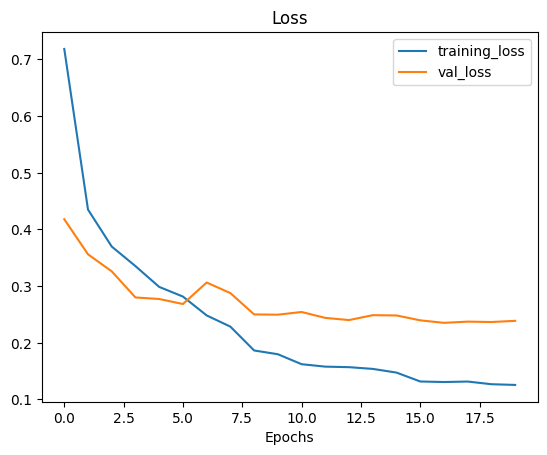

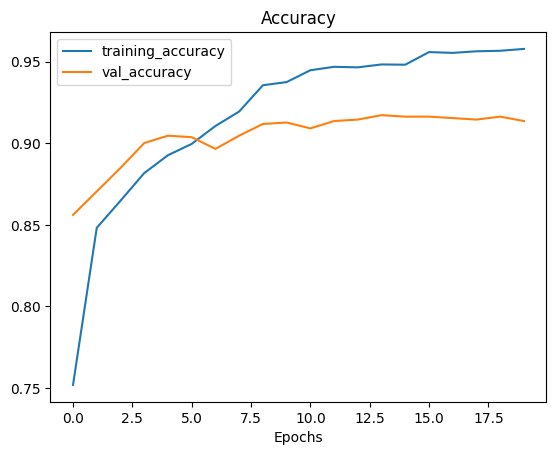

In [59]:
plot_loss_curves(ResNet101_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [60]:
test_loss, test_accuracy = ResNet101_model.evaluate(test_data, verbose=0)

In [61]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.23533
Test Accuracy: 92.15%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [62]:
pred_probs = ResNet101_model.predict(test_data, verbose=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 757ms/step


In [63]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0])

In [64]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [65]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

  biological       0.96      0.96      0.96        99
   cardboard       0.95      0.95      0.95       182
       glass       0.97      0.88      0.92       305
       metal       0.81      0.97      0.88       100
       paper       0.91      0.94      0.93       165
     plastic       0.87      0.90      0.88       192
       trash       0.95      0.92      0.94        78

    accuracy                           0.92      1121
   macro avg       0.92      0.93      0.92      1121
weighted avg       0.93      0.92      0.92      1121



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [66]:
import itertools

In [67]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

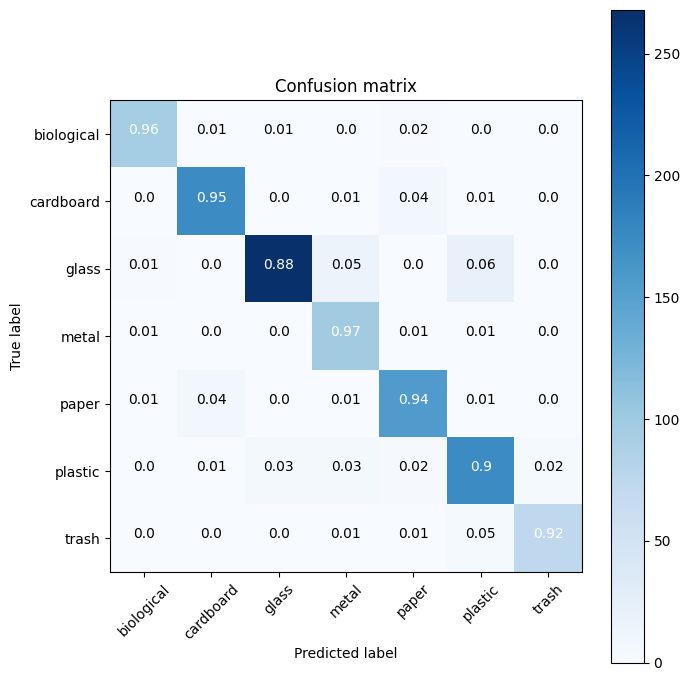

In [68]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [69]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        if i == 1:
            deploy_model_emission_tracker = EmissionsTracker()
            deploy_model_emission_tracker.start()
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            deploy_model_emissions: float = prepare_data_emission_tracker.stop()
            print(f"Deploy Model Carbon Emissions: {deploy_model_emissions} kg")
        else:
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

[codecarbon WARNING @ 03:06:40] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 03:06:40] [setup] RAM Tracking...
[codecarbon INFO @ 03:06:40] [setup] CPU Tracking...
[codecarbon WARNING @ 03:06:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 03:06:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 03:06:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 03:06:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 03:06:41] [setup] GPU Tracking...
[codecarbon INFO @ 03:06:41] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:06:41] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Deploy Model Carbon Emissions: 0.11079303509965976 kg


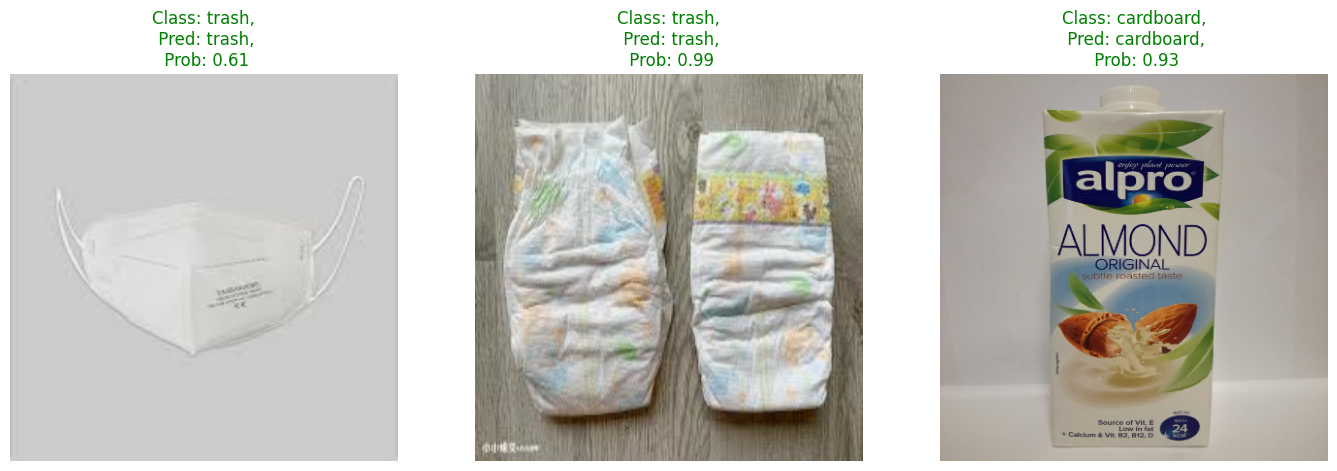

In [70]:
pred_random_images(ResNet101_model, test_path, class_names)

In [71]:
import pickle
pickle.dump(ResNet101_model,open("ResNet101_model.h5","wb"))

In [72]:
ls ../working

data/                      logs/               ResNet101.h5
emissions.csv              logs.zip            ResNet101_model.h5
garbage-classification.h5  __notebook__.ipynb  runs/
